<a href="https://colab.research.google.com/github/criscarmor/TFG-CCM/blob/main/Preprocesamiento_TODO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook se encarga de analizar y preparar los distintos datasets de contaminantes y clima para ser utilizados por los modelos. Este notebook solo limpia los datos, imputa por interpolación, etc...

La preparación de los datasets limpios para generar secuencias, lags o cualquier preparación específica del algoritmo empleado se realizará en cada uno de los notebooks propios de los algoritmos.

Para poder ejecutarlo, es necesario subir los archivos X.csv correspondientes, donde X designa al contaminante concreto.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def days_missing(df, estacion):
    dataframe_estacion = df[df["ESTACION"] == estacion]
    dataframe_estacion.head()

    dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
    fecha_inicio = dataframe_estacion['FECHA'].min()
    fecha_fin = dataframe_estacion['FECHA'].max()
    fechas_completas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

    fechas_presentes = set(dataframe_estacion['FECHA'].dt.date)
    fechas_completas_set = set(fechas_completas.date)
    fechas_faltantes = sorted(fechas_completas_set - fechas_presentes)

    return len(fechas_faltantes)

In [ ]:
def preparar_dataframe(df):
    import pandas as pd

    # Crear columna de fecha
    df["FECHA"] = pd.to_datetime(df[['ANNO', 'MES', 'DIA']].rename(columns={
        'ANNO': 'year', 'MES': 'month', 'DIA': 'day'
    }))

    # Transformar horas en filas separadas, mantener ESTACION
    df_melted = df.melt(id_vars=["FECHA", "ESTACION"],
                        value_vars=[f"H{str(i).zfill(2)}" for i in range(1, 25)],
                        var_name="HORA", value_name="CONCENTRACION")

    # Convertir la columna HORA a entero
    df_melted["HORA"] = df_melted["HORA"].str.extract("(\d+)").astype(int)

    # Ordenar por fecha y hora
    df_melted = df_melted.sort_values(by=["FECHA", "HORA"])

    # Crear FECHA_HORA combinando FECHA y HORA
    df_melted["FECHA_HORA"] = pd.to_datetime(df_melted["FECHA"]) + pd.to_timedelta(df_melted["HORA"] - 1, unit="h")

    # Seleccionar columnas necesarias
    df_final = df_melted[["FECHA_HORA", "ESTACION", "CONCENTRACION"]]
    df_final = df_final.sort_values("FECHA_HORA")
    df_final = df_final.set_index('FECHA_HORA')

    # Agregar variables temporales
    df_final["HORA"] = df_final.index.hour
    df_final["DIA_SEMANA"] = df_final.index.weekday
    df_final["DIA"] = df_final.index.day
    df_final["MES"] = df_final.index.month
    df_final["ANNO"] = df_final.index.year

    return df_final


In [ ]:
def eliminar_dias_incompletos(df):
    # Asegurar índice datetime y ordenado
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Crear rango horario completo
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    df_full = df.reindex(full_range)
    df_full.index.name = 'FECHA_HORA'

    # Contar registros válidos por día
    valid_counts = df_full['CONCENTRACION'].groupby(df_full.index.date).count()

    # Identificar días con menos de 18 registros
    dias_incompletos = valid_counts[valid_counts < 18].index

    # Eliminar todas las horas de esos días
    df_filtrado = df_full[~df_full.index.normalize().isin(pd.to_datetime(dias_incompletos))]

    return df_filtrado

# Preprocesamiento NO2

## Carga y análisis

In [ ]:
df_NO2 = pd.read_csv("NO2.csv", delimiter=";")

In [ ]:
df_NO2 = preparar_dataframe(df_NO2)

In [ ]:
resumen = df_NO2.groupby("ESTACION").agg(
    f_inicio=("CONCENTRACION", lambda x: x.index.min()),
    f_fin=("CONCENTRACION", lambda x: x.index.max()),
    min_con=("CONCENTRACION", "min"),
    max_con=("CONCENTRACION", "max"),
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())
)

# Añadir días faltantes con lambda
resumen["%_nulos"] = 100 * resumen["registros_nulos"] / resumen["registros_totales"]
resumen["dias_faltantes"] = resumen.index.to_series().apply(lambda estacion: days_missing(df_NO2, estacion))

/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-17964

In [ ]:
resumen.round(2)

,f_inicio,f_fin,min_con,max_con,registros_totales,registros_nulos,%_nulos,dias_faltantes
ESTACION,,,,,,,,
9,2014-01-01,2023-12-31 23:00:00,0.0,216.0,85440,1285,1.50,92
10,2014-01-01,2023-12-31 23:00:00,0.0,262.0,85152,1904,2.24,104
15,2014-01-01,2023-12-31 23:00:00,0.0,227.0,73776,1597,2.16,578
16,2014-01-01,2023-12-31 23:00:00,0.0,168.0,84744,1798,2.12,121
17,2014-01-01,2023-12-31 23:00:00,0.0,178.0,56328,1053,1.87,1305
18,2014-01-01,2023-12-31 23:00:00,0.0,319.0,67728,1458,2.15,830
19,2014-01-01,2023-12-31 23:00:00,0.0,144.0,66000,1388,2.10,902


In [ ]:
# Filtrar directamente por índice FECHA_HORA y estación 9
df_est9_dias = df_NO2[
    (df_NO2.index.date >= pd.to_datetime("2015-12-17").date()) &
    (df_NO2.index.date <= pd.to_datetime("2015-12-18").date()) &
    (df_NO2['ESTACION'] == 9)
]


In [ ]:
df_est9_dias

,ESTACION,CONCENTRACION,HORA,DIA_SEMANA,DIA,MES,ANNO
FECHA_HORA,,,,,,,
2015-12-17 00:00:00,9,59.0,0,3,17,12,2015
2015-12-17 01:00:00,9,48.0,1,3,17,12,2015
2015-12-17 02:00:00,9,37.0,2,3,17,12,2015
2015-12-17 03:00:00,9,37.0,3,3,17,12,2015
2015-12-17 04:00:00,9,40.0,4,3,17,12,2015
2015-12-17 05:00:00,9,46.0,5,3,17,12,2015
2015-12-17 06:00:00,9,75.0,6,3,17,12,2015
2015-12-17 07:00:00,9,89.0,7,3,17,12,2015
2015-12-17 08:00:00,9,69.0,8,3,17,12,2015


In [ ]:
df_est9_dias['original'] = df_est9_dias['CONCENTRACION'].notna().astype(int)

/tmp/ipython-input-11-1908415499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_est9_dias['original'] = df_est9_dias['CONCENTRACION'].notna().astype(int)


In [ ]:
df_est_9_dias_interpolado = df_est9_dias.interpolate(method='time')

In [ ]:
df_est_9_dias_interpolado

,ESTACION,CONCENTRACION,HORA,DIA_SEMANA,DIA,MES,ANNO,original
FECHA_HORA,,,,,,,,
2015-12-17 00:00:00,9,59.0,0,3,17,12,2015,1
2015-12-17 01:00:00,9,48.0,1,3,17,12,2015,1
2015-12-17 02:00:00,9,37.0,2,3,17,12,2015,1
2015-12-17 03:00:00,9,37.0,3,3,17,12,2015,1
2015-12-17 04:00:00,9,40.0,4,3,17,12,2015,1
2015-12-17 05:00:00,9,46.0,5,3,17,12,2015,1
2015-12-17 06:00:00,9,75.0,6,3,17,12,2015,1
2015-12-17 07:00:00,9,89.0,7,3,17,12,2015,1
2015-12-17 08:00:00,9,69.0,8,3,17,12,2015,1


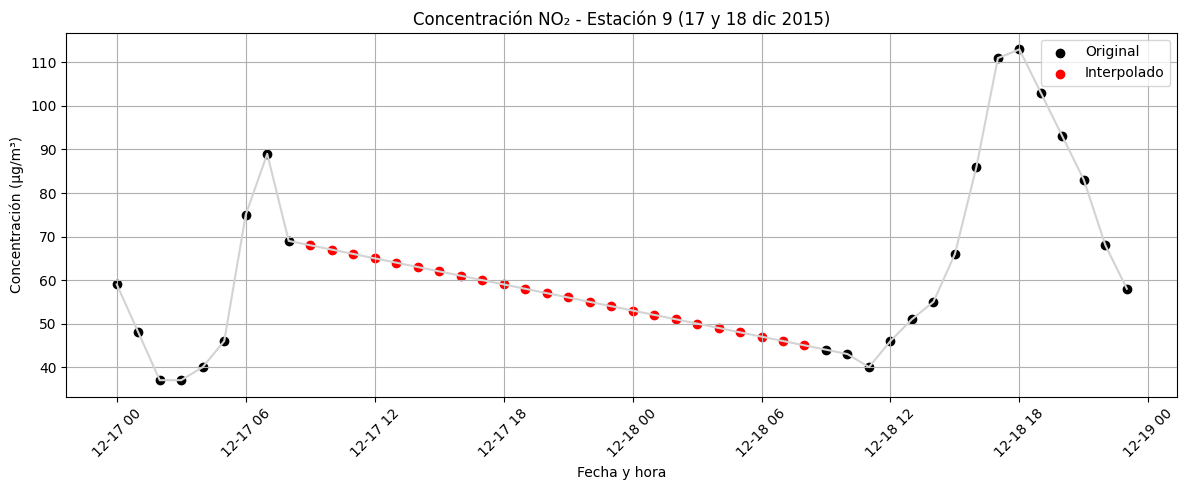

In [ ]:
# Crear gráfico
plt.figure(figsize=(12, 5))
plt.plot(df_est_9_dias_interpolado.index, df_est_9_dias_interpolado['CONCENTRACION'], color='lightgray', label='_')

# Puntos originales
plt.scatter(
    df_est_9_dias_interpolado.index[df_est_9_dias_interpolado['original'] == 1],
    df_est_9_dias_interpolado['CONCENTRACION'][df_est_9_dias_interpolado['original'] == 1],
    color='black', label='Original'
)

# Puntos interpolados
plt.scatter(
    df_est_9_dias_interpolado.index[df_est_9_dias_interpolado['original'] == 0],
    df_est_9_dias_interpolado['CONCENTRACION'][df_est_9_dias_interpolado['original'] == 0],
    color='red', label='Interpolado'
)

plt.title("Concentración NO₂ - Estación 9 (17 y 18 dic 2015)")
plt.xlabel("Fecha y hora")
plt.ylabel("Concentración (µg/m³)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

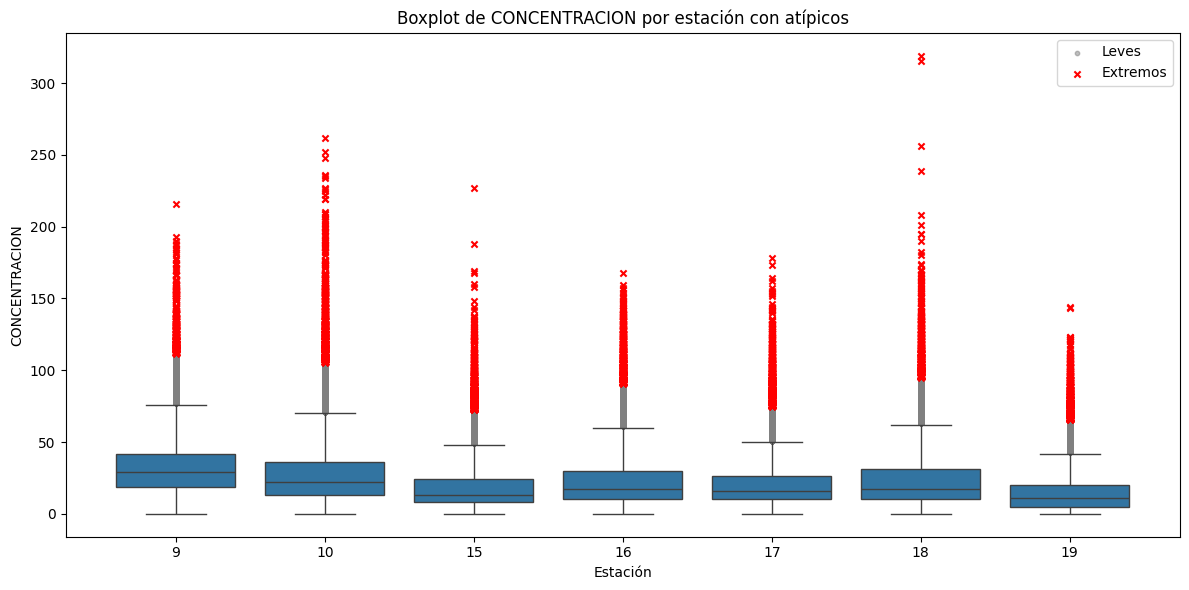

In [ ]:
plt.figure(figsize=(12, 6))
df_plot = df_NO2.copy().reset_index()

sns.boxplot(data=df_plot, x='ESTACION', y='CONCENTRACION', showfliers=False)

# Calcular y dibujar outliers leves y extremos manualmente
for i, estacion in enumerate(df_NO2['ESTACION'].unique()):
    datos = df_NO2[df_NO2['ESTACION'] == estacion]['CONCENTRACION'].dropna()
    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1
    mild_min = q1 - 1.5 * iqr
    mild_max = q3 + 1.5 * iqr
    extreme_min = q1 - 3 * iqr
    extreme_max = q3 + 3 * iqr

    # Separar valores leves y extremos
    outliers_leves = datos[(datos < mild_min) | (datos > mild_max)]
    outliers_leves = outliers_leves[(outliers_leves > extreme_min) & (outliers_leves < extreme_max)]

    outliers_extremos = datos[(datos < extreme_min) | (datos > extreme_max)]

    # Leves: círculos grises, extremos: cruces rojas
    plt.scatter([i] * len(outliers_leves), outliers_leves, color='gray', alpha=0.5, s=10, label='Leves' if i == 0 else "")
    plt.scatter([i] * len(outliers_extremos), outliers_extremos, color='red', marker='x', s=20, label='Extremos' if i == 0 else "")

plt.legend()
plt.title("Boxplot de CONCENTRACION por estación con atípicos")
plt.ylabel("CONCENTRACION")
plt.xlabel("Estación")
plt.tight_layout()
plt.show()


## Eliminar días con menos de 18 medidas

In [ ]:
df_NO2['original'] = df_NO2['CONCENTRACION'].notna().astype(int)

In [ ]:
# Crear un DataFrame vacío para acumular resultados
dfs_procesados = []

# Iterar sobre cada estación única
for estacion in df_NO2['ESTACION'].unique():
    # Filtrar por estación
    df_estacion = df_NO2[df_NO2['ESTACION'] == estacion]

    # Eliminar días incompletos
    df_limpio = eliminar_dias_incompletos(df_estacion)

    # Asegurarse de que el índice esté en datetime y ordenado
    df_limpio = df_limpio.sort_index()
    df_limpio.index = pd.to_datetime(df_limpio.index)

    # Interpolación temporal
    df_limpio['CONCENTRACION'] = df_limpio['CONCENTRACION'].interpolate(method='time')

    # Guardar resultado
    dfs_procesados.append(df_limpio)

# Concatenar todos los resultados
df_NO2_interpolado = pd.concat(dfs_procesados)


/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' inste

In [ ]:
df_NO2_9 = df_NO2_interpolado[df_NO2_interpolado['ESTACION'] == 9]

In [ ]:
# Filtrar directamente por índice FECHA_HORA y estación 9
df_primero = df_NO2_9[
    df_NO2_9.index.date == pd.to_datetime("2015-09-01").date()
]

In [ ]:
# Filtrar directamente por índice FECHA_HORA y estación 9
df_segundo = df_NO2_9[
    (df_NO2_9.index.date >= pd.to_datetime("2015-05-07").date()) &
    (df_NO2_9.index.date <= pd.to_datetime("2015-05-21").date())
]

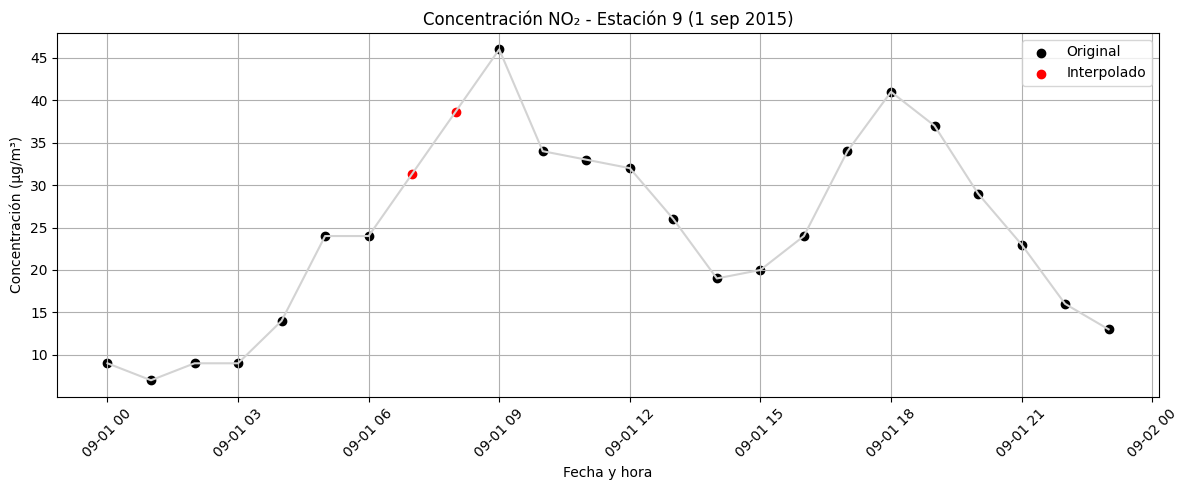

In [ ]:
# Crear gráfico
plt.figure(figsize=(12, 5))
plt.plot(df_primero.index, df_primero['CONCENTRACION'], color='lightgray', label='_')

# Puntos originales (negro)
plt.scatter(
    df_primero.index[df_primero['original'] == 1],
    df_primero['CONCENTRACION'][df_primero['original'] == 1],
    color='black', label='Original'
)

# Puntos interpolados (rojo)
plt.scatter(
    df_primero.index[df_primero['original'] == 0],
    df_primero['CONCENTRACION'][df_primero['original'] == 0],
    color='red', label='Interpolado'
)

plt.title("Concentración NO₂ - Estación 9 (1 sep 2015)")
plt.xlabel("Fecha y hora")
plt.ylabel("Concentración (µg/m³)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

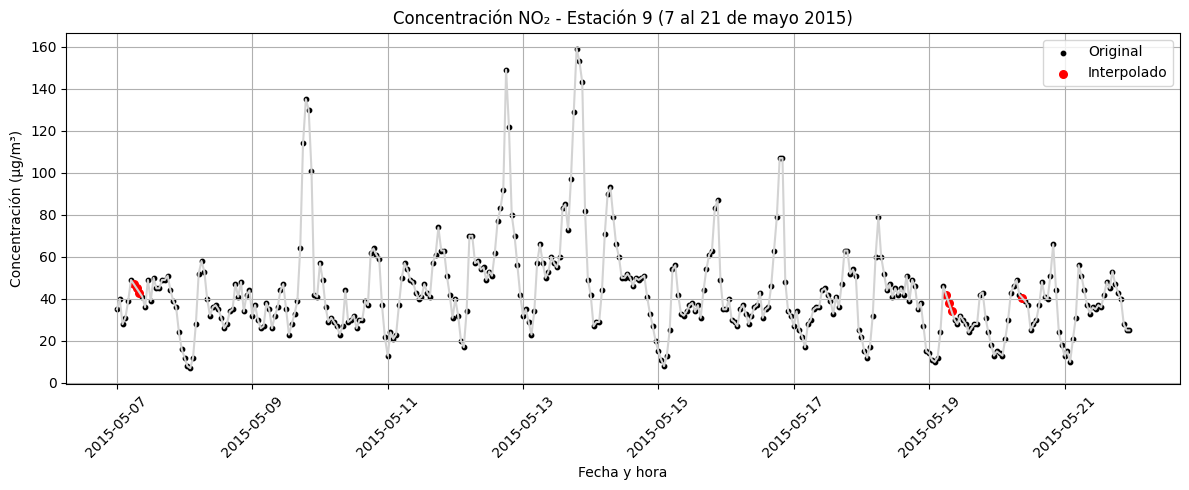

In [ ]:
# Crear gráfico
plt.figure(figsize=(12, 5))
plt.plot(df_segundo.index, df_segundo['CONCENTRACION'], color='lightgray', label='_')

# Puntos originales (negro)
plt.scatter(
    df_segundo.index[df_segundo['original'] == 1],
    df_segundo['CONCENTRACION'][df_segundo['original'] == 1],
    color='black', label='Original', s=10
)

# Puntos interpolados (rojo)
plt.scatter(
    df_segundo.index[df_segundo['original'] == 0],
    df_segundo['CONCENTRACION'][df_segundo['original'] == 0],
    color='red', label='Interpolado', s= 30
)

plt.title("Concentración NO₂ - Estación 9 (7 al 21 de mayo 2015)")
plt.xlabel("Fecha y hora")
plt.ylabel("Concentración (µg/m³)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

dias = pd.date_range(start="2014-01-01", end="2023-12-31", freq="D")
print(len(dias))


3652


In [ ]:
resumen2 = df_NO2_interpolado.groupby("ESTACION").agg(
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())

)

#resumen2["%_nulos"] = 100 * resumen2["registros_nulos"] / resumen2["registros_totales"]
resumen2["dias_faltantes_anteriores"] = resumen["dias_faltantes"]
resumen2["dias_faltantes"] = resumen2.index.to_series().apply(lambda estacion: days_missing(df_NO2_interpolado, estacion))
resumen2["%_faltante_total"] = (resumen2["dias_faltantes"] / len(dias))*100

/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-17964

In [ ]:
resumen2.round(2)

,registros_totales,registros_nulos,dias_faltantes_anteriores,dias_faltantes,%_faltante_total
ESTACION,,,,,
9.0,84504,0,92,131,3.59
10.0,83328,0,104,180,4.93
15.0,72072,0,578,649,17.77
16.0,83184,0,121,186,5.09
17.0,55272,0,1305,1349,36.94
18.0,66072,0,830,899,24.62
19.0,64512,0,902,964,26.40


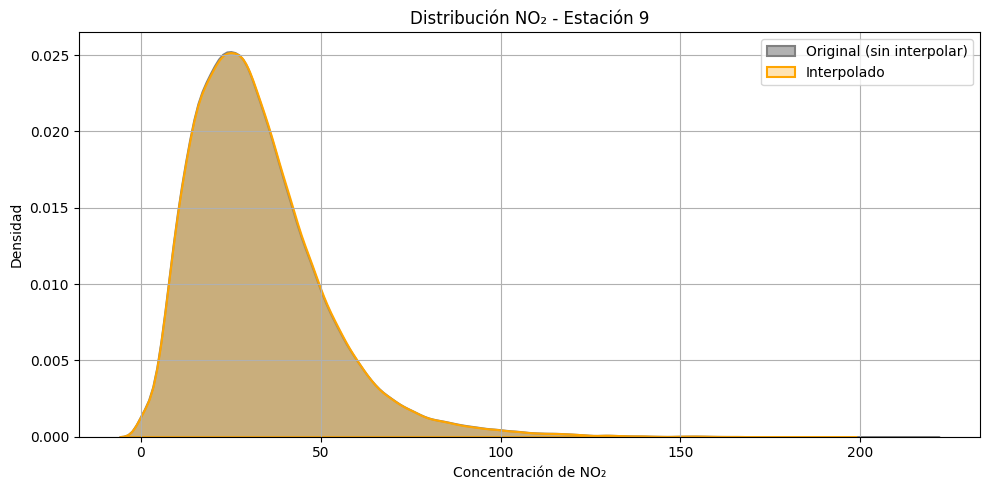

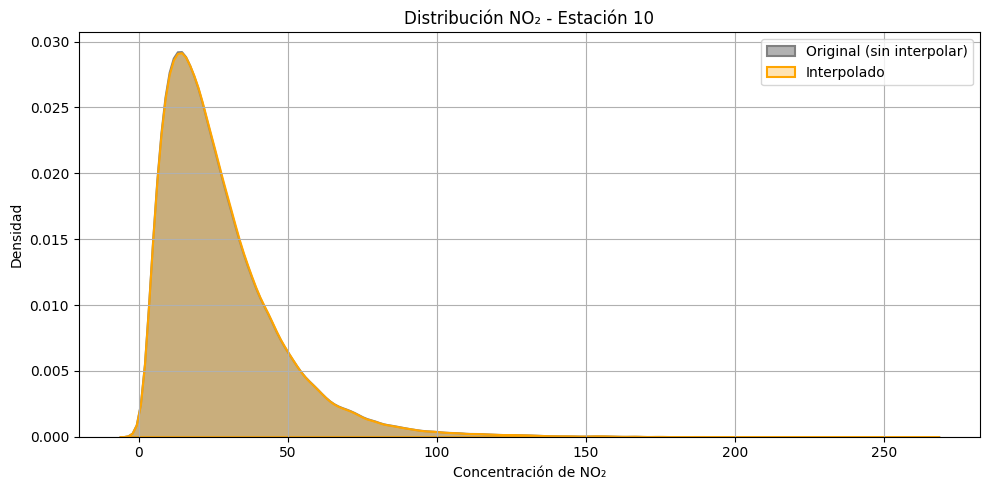

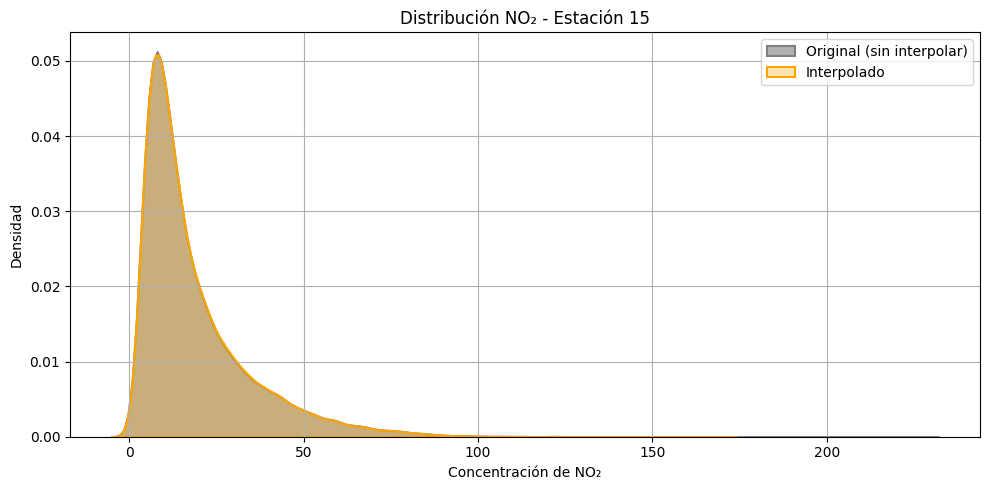

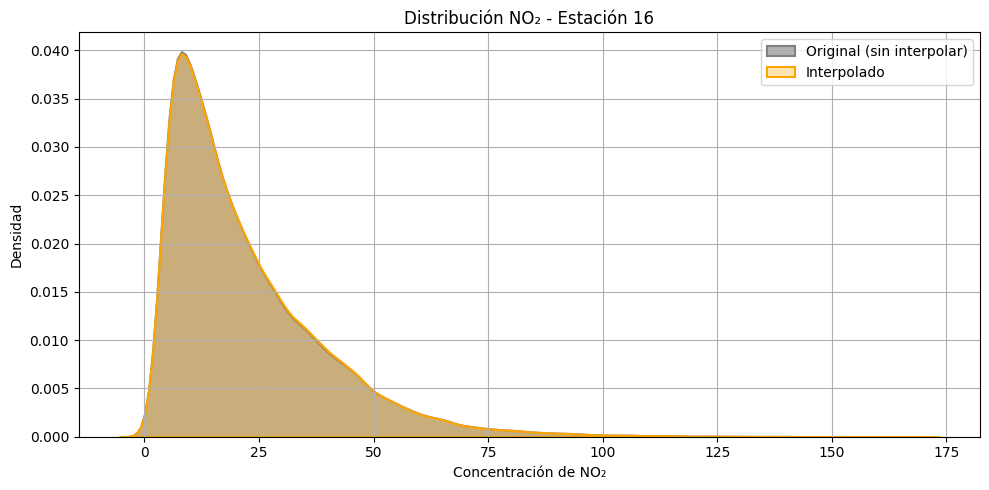

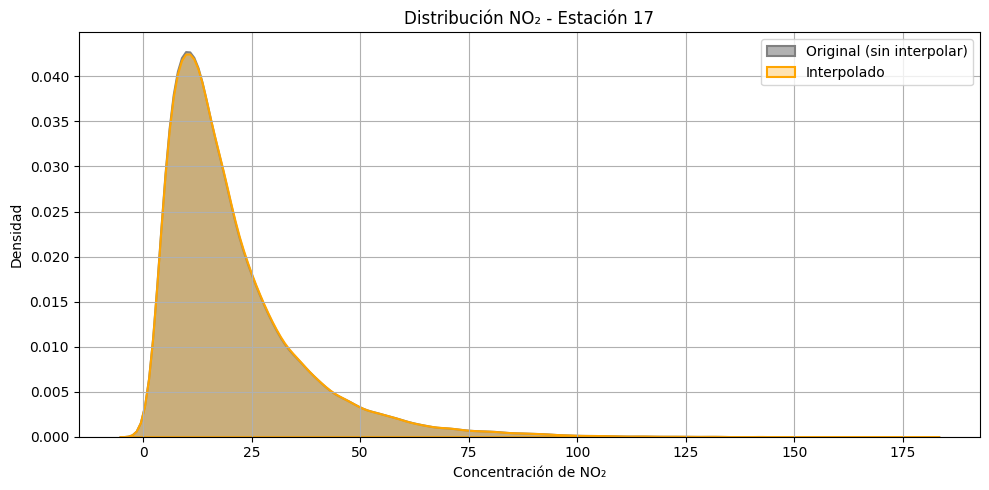

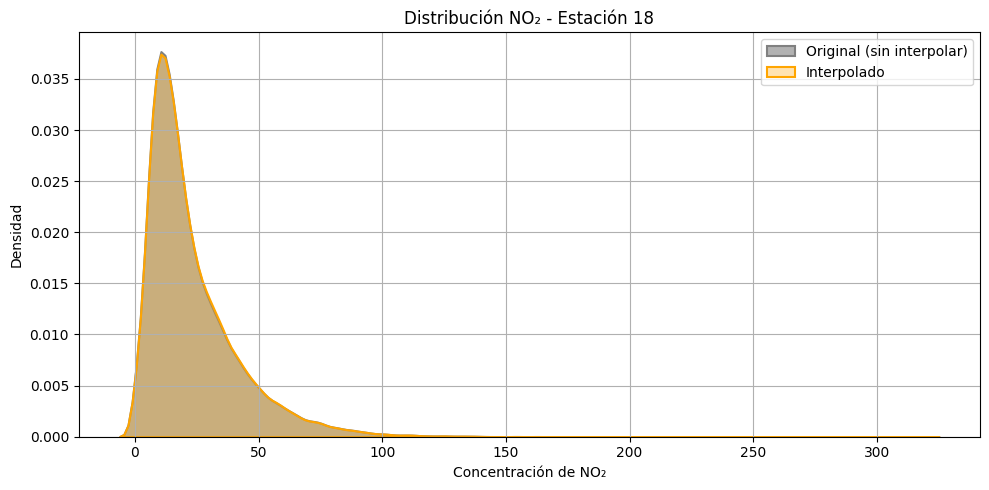

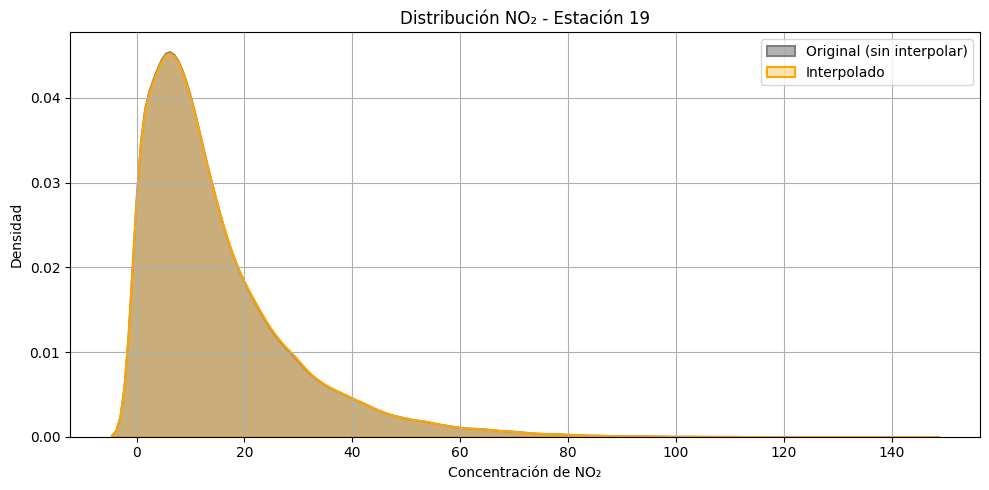

    ESTACION         Tipo      Media  Desviación estándar   P25  \
1          9  Interpolado  32.501487            18.781173  19.0   
0          9     Original  32.466591            18.897306  19.0   
3         10  Interpolado  27.401999            20.165525  13.0   
2         10     Original  27.405391            20.269202  13.0   
5         15  Interpolado  18.854672            15.860575   8.0   
4         15     Original  18.837169            15.952064   8.0   
7         16  Interpolado  22.244666            17.230644  10.0   
6         16     Original  22.192595            17.280555  10.0   
9         17  Interpolado  20.412291            15.911717  10.0   
8         17     Original  20.366658            15.926760  10.0   
11        18  Interpolado  23.202162            18.688396  10.0   
10        18     Original  23.142251            18.723401  10.0   
13        19  Interpolado  15.009632            14.225840   5.0   
12        19     Original  14.955132            14.222757   5.

In [ ]:
# 1. Eliminar nulos de df_NO2 (solo donde hay datos reales)
df_original = df_NO2[['ESTACION', 'CONCENTRACION']].dropna()

# 2. Copiar df_NO2_interpolado asegurando columnas necesarias
df_interpolado = df_NO2_interpolado[['ESTACION', 'CONCENTRACION']].copy()

# 3. Inicializar lista para guardar estadísticas
estadisticas = []

# 4. Iterar por cada estación única
for estacion in sorted(df_original['ESTACION'].unique()):
    datos_orig = df_original[df_original['ESTACION'] == estacion]['CONCENTRACION']
    datos_interp = df_interpolado[df_interpolado['ESTACION'] == estacion]['CONCENTRACION']

    # Graficar KDE
    plt.figure(figsize=(10, 5))
    sns.kdeplot(datos_orig, label='Original (sin interpolar)', fill=True, color='gray', alpha=0.6, linewidth=1.5)
    sns.kdeplot(datos_interp, label='Interpolado', fill=True, color='orange', alpha=0.3, linewidth=1.5)
    plt.title(f'Distribución NO₂ - Estación {estacion}')
    plt.xlabel('Concentración de NO₂')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calcular estadísticas y agregarlas
    for tipo, datos in zip(['Original', 'Interpolado'], [datos_orig, datos_interp]):
        estadisticas.append({
            'ESTACION': estacion,
            'Tipo': tipo,
            'Media': datos.mean(),
            'Desviación estándar': datos.std(),
            'P25': np.percentile(datos, 25),
            'P50 (Mediana)': np.percentile(datos, 50),
            'P75': np.percentile(datos, 75)
        })

# 5. Crear DataFrame resumen
resumen_df = pd.DataFrame(estadisticas)

# 6. Mostrar tabla ordenada
resumen_df = resumen_df.sort_values(['ESTACION', 'Tipo'])
print(resumen_df)


In [ ]:
resumen_df

,ESTACION,Tipo,Media,Desviación estándar,P25,P50 (Mediana),P75
1,9,Interpolado,32.501487,18.781173,19.0,29.0,42.0
0,9,Original,32.466591,18.897306,19.0,29.0,42.0
3,10,Interpolado,27.401999,20.165525,13.0,22.0,36.0
2,10,Original,27.405391,20.269202,13.0,22.0,36.0
5,15,Interpolado,18.854672,15.860575,8.0,13.0,25.0
4,15,Original,18.837169,15.952064,8.0,13.0,24.0
7,16,Interpolado,22.244666,17.230644,10.0,17.0,30.0
6,16,Original,22.192595,17.280555,10.0,17.0,30.0
9,17,Interpolado,20.412291,15.911717,10.0,16.0,26.0
8,17,Original,20.366658,15.926760,10.0,16.0,26.0


In [ ]:
# 1. Eliminar nulos de df_NO2 (solo donde hay datos reales)
df_original = df_NO2[['ESTACION', 'CONCENTRACION']].dropna()

# 2. Copiar df_NO2_interpolado asegurando columnas necesarias
df_interpolado = df_NO2_interpolado[['ESTACION', 'CONCENTRACION']].copy()

# 3. Inicializar lista para guardar estadísticas
estadisticas = []

# 4. Iterar por cada estación única
for estacion in sorted(df_original['ESTACION'].unique()):
    datos_orig = df_original[df_original['ESTACION'] == estacion]['CONCENTRACION']
    datos_interp = df_interpolado[df_interpolado['ESTACION'] == estacion]['CONCENTRACION']


    datos_2023 = datos_orig[datos_orig.index.year == 2023]
    datos_2023_interp = datos_interp[datos_interp.index.year == 2023]
    # UMA% para NO2
    UMA_percent = 0.25

# Calcular incertidumbre de cada dato observado
    incertidumbres = UMA_percent * datos_2023

# Calcular RMS_U
    RMS_U = np.sqrt(np.mean(incertidumbres**2))
    # Calcular estadísticas y agregarlas
    for tipo, datos in zip(['Original', 'Interpolado'], [datos_2023, datos_2023_interp]):
        estadisticas.append({
            'ESTACION': estacion,
            'Tipo': tipo,
            'RMS_U': RMS_U,
            'Media': datos.mean(),
            'Desviación estándar': datos.std(),
            'P25': np.percentile(datos, 25),
            'P50 (Mediana)': np.percentile(datos, 50),
            'P75': np.percentile(datos, 75)
        })

# 5. Crear DataFrame resumen
resumen_df = pd.DataFrame(estadisticas)

# 6. Mostrar tabla ordenada
resumen_df = resumen_df.sort_values(['ESTACION', 'Tipo'])
print(resumen_df)


    ESTACION         Tipo     RMS_U      Media  Desviación estándar   P25  \
1          9  Interpolado  7.409912  25.573443            14.954714  16.0   
0          9     Original  7.409912  25.548921            15.026242  15.0   
3         10  Interpolado  7.281072  23.349170            17.441129  11.0   
2         10     Original  7.281072  23.292151            17.485310  11.0   
5         15  Interpolado  5.403810  16.389461            14.067129   7.0   
4         15     Original  5.403810  16.395309            14.086762   7.0   
7         16  Interpolado  5.916462  18.722569            14.556091   8.0   
6         16     Original  5.916462  18.640316            14.582031   8.0   
9         17  Interpolado  5.060301  15.572222            12.844982   8.0   
8         17     Original  5.060301  15.533153            12.980891   8.0   
11        18  Interpolado  6.649027  20.656776            16.743040  10.0   
10        18     Original  6.649027  20.625352            16.792290  10.0   

## Cálculo variables cíclicas

In [ ]:
df_NO2_interpolado['hora_sin'] = np.sin(2 * np.pi * df_NO2_interpolado['HORA'] / 24)
df_NO2_interpolado['hora_cos'] = np.cos(2 * np.pi * df_NO2_interpolado['HORA'] / 24)
df_NO2_interpolado['dia_semana_sin'] = np.sin(2 * np.pi * df_NO2_interpolado['DIA_SEMANA'] / 7)
df_NO2_interpolado['dia_semana_cos'] = np.cos(2 * np.pi * df_NO2_interpolado['DIA_SEMANA'] / 7)
df_NO2_interpolado['mes_sin'] = np.sin(2 * np.pi * df_NO2_interpolado['MES'] / 12)
df_NO2_interpolado['mes_cos'] = np.cos(2 * np.pi * df_NO2_interpolado['MES'] / 12)

df_NO2_interpolado.drop(columns=['HORA', 'DIA_SEMANA', 'MES', 'ANNO', 'DIA', 'original'], inplace=True)


In [ ]:
df_NO2_interpolado

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2014-01-01 00:00:00,9.0,61.0,0.000000,1.000000,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 01:00:00,9.0,60.0,0.258819,0.965926,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 02:00:00,9.0,51.0,0.500000,0.866025,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 03:00:00,9.0,39.0,0.707107,0.707107,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 04:00:00,9.0,31.0,0.866025,0.500000,0.974928,-0.222521,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.0,38.0,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 20:00:00,19.0,35.0,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 21:00:00,19.0,21.0,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000


In [ ]:
df_NO2_interpolado.to_csv('NO2_data_final.csv', index=True, index_label='FECHA_HORA')

# Preprocesamiento SO2

## Carga y análisis

In [ ]:
df_SO2 = pd.read_csv("SO2.csv", delimiter=";")

In [ ]:
df_SO2 = preparar_dataframe(df_SO2)

In [ ]:
resumen = df_SO2.groupby("ESTACION").agg(
    f_inicio=("CONCENTRACION", lambda x: x.index.min()),
    f_fin=("CONCENTRACION", lambda x: x.index.max()),
    min_con=("CONCENTRACION", "min"),
    max_con=("CONCENTRACION", "max"),
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())
)

# Añadir días faltantes con lambda
resumen["%_nulos"] = 100 * resumen["registros_nulos"] / resumen["registros_totales"]
resumen["dias_faltantes"] = resumen.index.to_series().apply(lambda estacion: days_missing(df_SO2, estacion))

<ipython-input-2-f571cb8ca951>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
<ipython-input-2-f571cb8ca951>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
<ipython-input-2-f571cb8ca951>:5: 

In [ ]:
resumen.round(2)

,f_inicio,f_fin,min_con,max_con,registros_totales,registros_nulos,%_nulos,dias_faltantes
ESTACION,,,,,,,,
9,2014-01-01,2023-12-31 23:00:00,0.0,49.0,86232,1208,1.40,59
10,2014-01-01,2023-12-31 23:00:00,0.0,59.0,84984,1738,2.05,111
16,2014-01-01,2023-12-31 23:00:00,0.0,41.0,86640,1761,2.03,42
18,2014-01-01,2023-12-31 23:00:00,0.0,73.0,85488,1953,2.28,90
19,2014-01-01,2023-12-31 23:00:00,0.0,46.0,86160,1048,1.22,62


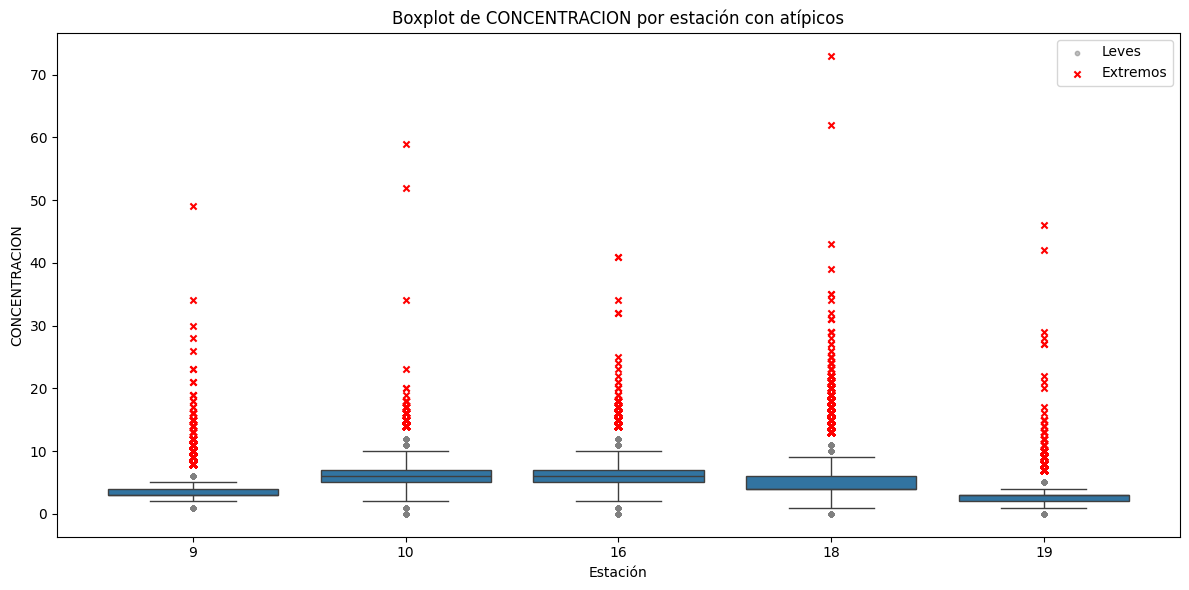

In [ ]:
plt.figure(figsize=(12, 6))
df_plot = df_SO2.copy().reset_index()

sns.boxplot(data=df_plot, x='ESTACION', y='CONCENTRACION', showfliers=False)

# Calcular y dibujar outliers leves y extremos manualmente
for i, estacion in enumerate(df_SO2['ESTACION'].unique()):
    datos = df_SO2[df_SO2['ESTACION'] == estacion]['CONCENTRACION'].dropna()
    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1
    mild_min = q1 - 1.5 * iqr
    mild_max = q3 + 1.5 * iqr
    extreme_min = q1 - 3 * iqr
    extreme_max = q3 + 3 * iqr

    # Separar valores leves y extremos
    outliers_leves = datos[(datos < mild_min) | (datos > mild_max)]
    outliers_leves = outliers_leves[(outliers_leves > extreme_min) & (outliers_leves < extreme_max)]

    outliers_extremos = datos[(datos < extreme_min) | (datos > extreme_max)]

    # Leves: círculos grises, extremos: cruces rojas
    plt.scatter([i] * len(outliers_leves), outliers_leves, color='gray', alpha=0.5, s=10, label='Leves' if i == 0 else "")
    plt.scatter([i] * len(outliers_extremos), outliers_extremos, color='red', marker='x', s=20, label='Extremos' if i == 0 else "")

plt.legend()
plt.title("Boxplot de CONCENTRACION por estación con atípicos")
plt.ylabel("CONCENTRACION")
plt.xlabel("Estación")
plt.tight_layout()
plt.show()


## Eliminar días con menos de 18 medidas

In [ ]:
df_SO2['original'] = df_SO2['CONCENTRACION'].notna().astype(int)

In [ ]:
# Crear un DataFrame vacío para acumular resultados
dfs_procesados = []

# Iterar sobre cada estación única
for estacion in df_SO2['ESTACION'].unique():
    # Filtrar por estación
    df_estacion = df_SO2[df_SO2['ESTACION'] == estacion]

    # Eliminar días incompletos
    df_limpio = eliminar_dias_incompletos(df_estacion)

    # Asegurarse de que el índice esté en datetime y ordenado
    df_limpio = df_limpio.sort_index()
    df_limpio.index = pd.to_datetime(df_limpio.index)

    # Interpolación temporal
    df_limpio['CONCENTRACION'] = df_limpio['CONCENTRACION'].interpolate(method='time')

    # Guardar resultado
    dfs_procesados.append(df_limpio)

# Concatenar todos los resultados
df_SO2_interpolado = pd.concat(dfs_procesados)


<ipython-input-4-0270e46a2045>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
<ipython-input-4-0270e46a2045>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
<ipython-input-4-0270e46a2045>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
<ipython-input-4-0270e46a2045>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
<ipython-input-4-0270e46a2045>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = p

In [ ]:

dias = pd.date_range(start="2014-01-01", end="2023-12-31", freq="D")
print(len(dias))  # Resultado: 3653


3652


In [ ]:
resumen2 = df_SO2_interpolado.groupby("ESTACION").agg(
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())

)

#resumen2["%_nulos"] = 100 * resumen2["registros_nulos"] / resumen2["registros_totales"]
resumen2["dias_faltantes_anteriores"] = resumen["dias_faltantes"]
resumen2["dias_faltantes"] = resumen2.index.to_series().apply(lambda estacion: days_missing(df_SO2_interpolado, estacion))
resumen2["%_faltante_total"] = (resumen2["dias_faltantes"] / len(dias))*100

<ipython-input-2-f571cb8ca951>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
<ipython-input-2-f571cb8ca951>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
<ipython-input-2-f571cb8ca951>:5: 

In [ ]:
resumen2.round(2)

,registros_totales,registros_nulos,dias_faltantes_anteriores,dias_faltantes,%_faltante_total
ESTACION,,,,,
9.0,85344,0,59,96,2.63
10.0,83352,0,111,179,4.90
16.0,85224,0,42,101,2.77
18.0,83112,0,90,189,5.18
19.0,85416,0,62,93,2.55


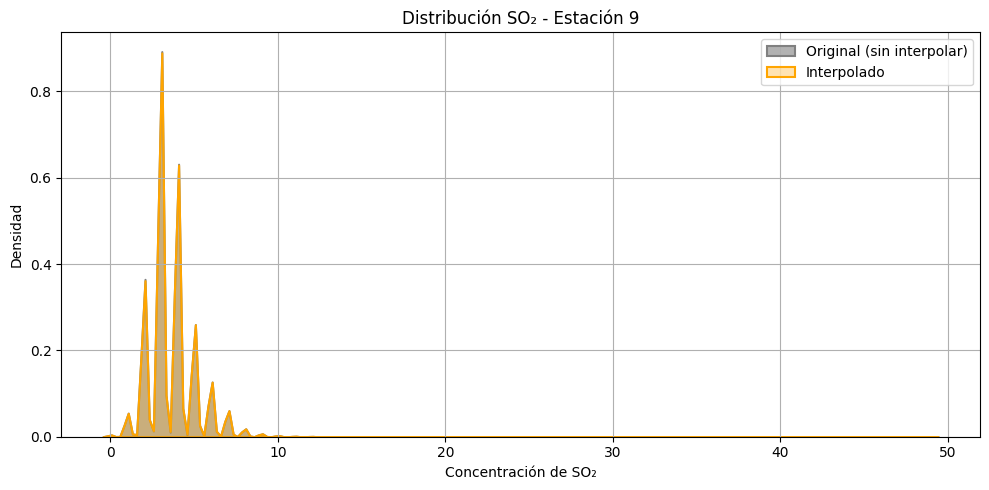

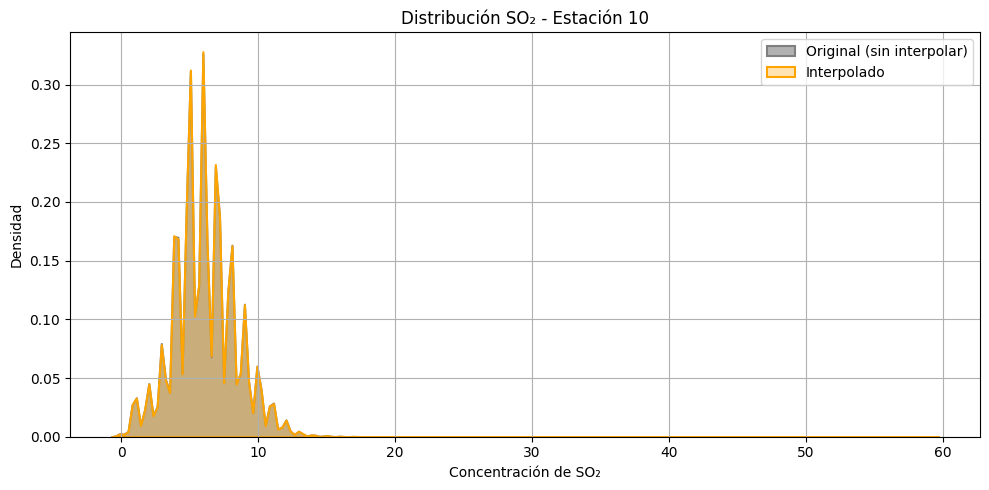

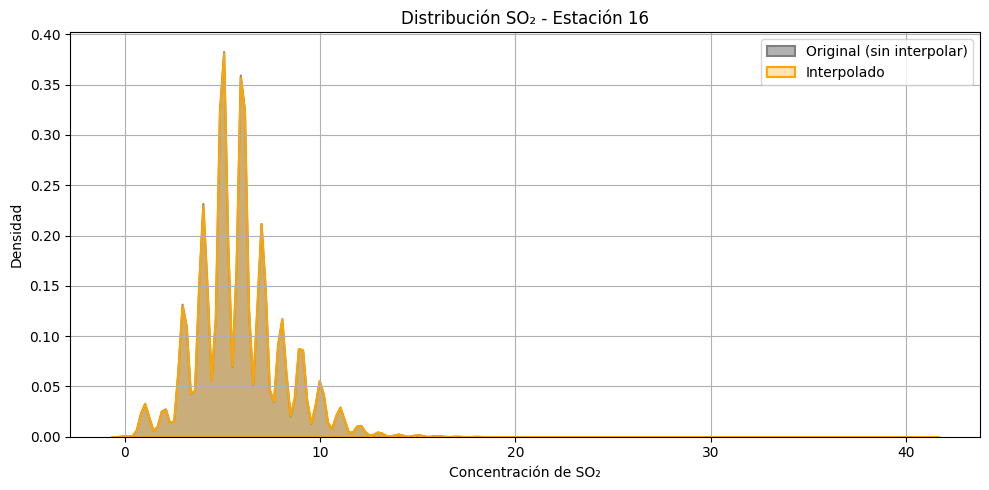

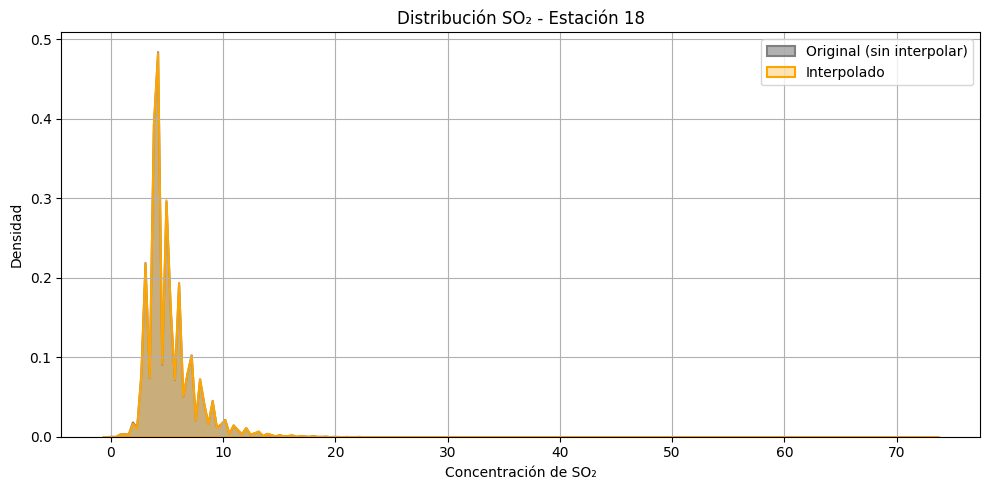

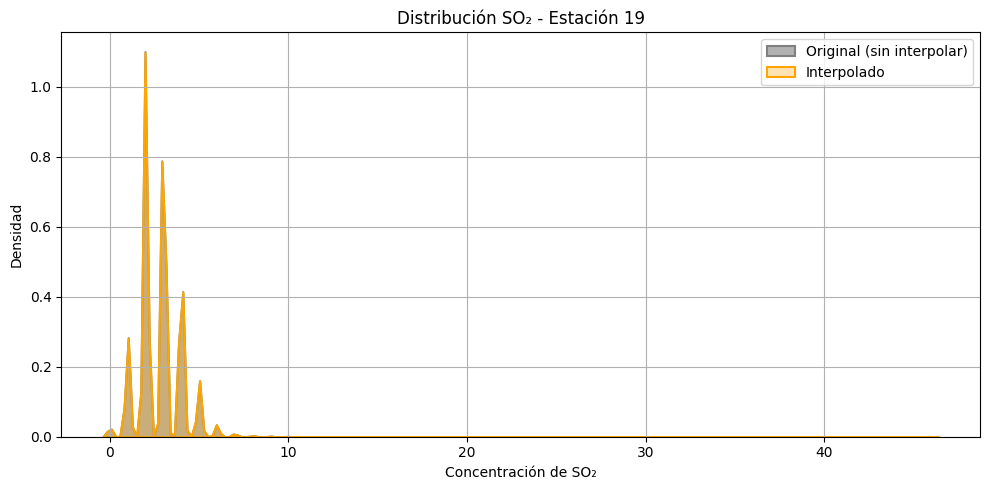

   ESTACION         Tipo     Media  Desviación estándar  P25  P50 (Mediana)  \
1         9  Interpolado  3.628738             1.424504  3.0           3.00   
0         9     Original  3.626294             1.426246  3.0           3.00   
3        10  Interpolado  6.094575             2.253395  5.0           6.00   
2        10     Original  6.093794             2.261773  5.0           6.00   
5        16  Interpolado  5.857127             2.201555  5.0           6.00   
4        16     Original  5.846322             2.198784  5.0           6.00   
7        18  Interpolado  5.186297             2.262720  4.0           4.75   
6        18     Original  5.181110             2.267817  4.0           4.00   
9        19  Interpolado  2.773408             1.208988  2.0           3.00   
8        19     Original  2.771478             1.209117  2.0           3.00   

   P75  
1  4.0  
0  4.0  
3  7.0  
2  7.0  
5  7.0  
4  7.0  
7  6.0  
6  6.0  
9  3.0  
8  3.0  


In [ ]:
# 1. Eliminar nulos de df_SO2 (solo donde hay datos reales)
df_original = df_SO2[['ESTACION', 'CONCENTRACION']].dropna()

# 2. Copiar df_SO2_interpolado asegurando columnas necesarias
df_interpolado = df_SO2_interpolado[['ESTACION', 'CONCENTRACION']].copy()

# 3. Inicializar lista para guardar estadísticas
estadisticas = []

# 4. Iterar por cada estación única
for estacion in sorted(df_original['ESTACION'].unique()):
    datos_orig = df_original[df_original['ESTACION'] == estacion]['CONCENTRACION']
    datos_interp = df_interpolado[df_interpolado['ESTACION'] == estacion]['CONCENTRACION']

    # Graficar KDE
    plt.figure(figsize=(10, 5))
    sns.kdeplot(datos_orig, label='Original (sin interpolar)', fill=True, color='gray', alpha=0.6, linewidth=1.5)
    sns.kdeplot(datos_interp, label='Interpolado', fill=True, color='orange', alpha=0.3, linewidth=1.5)
    plt.title(f'Distribución SO₂ - Estación {estacion}')
    plt.xlabel('Concentración de SO₂')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calcular estadísticas y agregarlas
    for tipo, datos in zip(['Original', 'Interpolado'], [datos_orig, datos_interp]):
        estadisticas.append({
            'ESTACION': estacion,
            'Tipo': tipo,
            'Media': datos.mean(),
            'Desviación estándar': datos.std(),
            'P25': np.percentile(datos, 25),
            'P50 (Mediana)': np.percentile(datos, 50),
            'P75': np.percentile(datos, 75)
        })

# 5. Crear DataFrame resumen
resumen_df = pd.DataFrame(estadisticas)

# 6. Mostrar tabla ordenada
resumen_df = resumen_df.sort_values(['ESTACION', 'Tipo'])
print(resumen_df)


In [ ]:
resumen_df

,ESTACION,Tipo,Media,Desviación estándar,P25,P50 (Mediana),P75
1,9,Interpolado,3.628738,1.424504,3.0,3.00,4.0
0,9,Original,3.626294,1.426246,3.0,3.00,4.0
3,10,Interpolado,6.094575,2.253395,5.0,6.00,7.0
2,10,Original,6.093794,2.261773,5.0,6.00,7.0
5,16,Interpolado,5.857127,2.201555,5.0,6.00,7.0
4,16,Original,5.846322,2.198784,5.0,6.00,7.0
7,18,Interpolado,5.186297,2.262720,4.0,4.75,6.0
6,18,Original,5.181110,2.267817,4.0,4.00,6.0
9,19,Interpolado,2.773408,1.208988,2.0,3.00,3.0
8,19,Original,2.771478,1.209117,2.0,3.00,3.0


## Cálculo variables cíclicas

In [ ]:
df_SO2_interpolado['hora_sin'] = np.sin(2 * np.pi * df_SO2_interpolado['HORA'] / 24)
df_SO2_interpolado['hora_cos'] = np.cos(2 * np.pi * df_SO2_interpolado['HORA'] / 24)
df_SO2_interpolado['dia_semana_sin'] = np.sin(2 * np.pi * df_SO2_interpolado['DIA_SEMANA'] / 7)
df_SO2_interpolado['dia_semana_cos'] = np.cos(2 * np.pi * df_SO2_interpolado['DIA_SEMANA'] / 7)
df_SO2_interpolado['mes_sin'] = np.sin(2 * np.pi * df_SO2_interpolado['MES'] / 12)
df_SO2_interpolado['mes_cos'] = np.cos(2 * np.pi * df_SO2_interpolado['MES'] / 12)

df_SO2_interpolado.drop(columns=['HORA', 'DIA_SEMANA', 'MES', 'ANNO', 'DIA', 'original'], inplace=True)


In [ ]:
df_SO2_interpolado

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2014-01-01 00:00:00,9.0,8.0,0.000000,1.000000,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 01:00:00,9.0,8.0,0.258819,0.965926,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 02:00:00,9.0,7.0,0.500000,0.866025,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 03:00:00,9.0,5.0,0.707107,0.707107,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 04:00:00,9.0,5.0,0.866025,0.500000,0.974928,-0.222521,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.0,5.0,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 20:00:00,19.0,5.0,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 21:00:00,19.0,5.0,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000


In [ ]:
df_SO2_interpolado.to_csv('SO2_data_final.csv', index=True, index_label='FECHA_HORA')

In [ ]:
df_SO2_interpolado[df_SO2_interpolado['ESTACION']==9][:312]

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2014-01-01 00:00:00,9.0,8.0,0.000000,1.000000,0.974928,-0.222521,0.5,0.866025
2014-01-01 01:00:00,9.0,8.0,0.258819,0.965926,0.974928,-0.222521,0.5,0.866025
2014-01-01 02:00:00,9.0,7.0,0.500000,0.866025,0.974928,-0.222521,0.5,0.866025
2014-01-01 03:00:00,9.0,5.0,0.707107,0.707107,0.974928,-0.222521,0.5,0.866025
2014-01-01 04:00:00,9.0,5.0,0.866025,0.500000,0.974928,-0.222521,0.5,0.866025
...,...,...,...,...,...,...,...,...
2014-01-19 19:00:00,9.0,1.0,-0.965926,0.258819,-0.781831,0.623490,0.5,0.866025
2014-01-19 20:00:00,9.0,2.0,-0.866025,0.500000,-0.781831,0.623490,0.5,0.866025
2014-01-19 21:00:00,9.0,2.0,-0.707107,0.707107,-0.781831,0.623490,0.5,0.866025


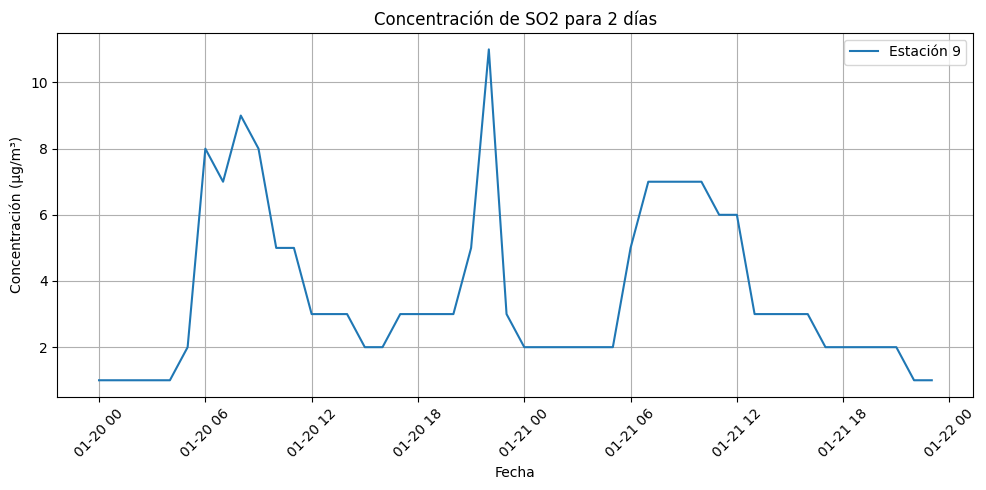

In [ ]:

df_est9 = df_SO2_interpolado[df_SO2_interpolado['ESTACION'] == 9][312:360]

# Graficar solo concentración con respecto a la fecha
plt.figure(figsize=(10, 5))
plt.plot( df_est9['CONCENTRACION'], label='Estación 9')
plt.xlabel('Fecha')
plt.ylabel('Concentración (μg/m³)')
plt.title('Concentración de SO2 para 2 días')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Preprocesamiento O3


## Carga y análisis

In [ ]:
df_O3 = pd.read_csv("O3.csv", delimiter=";")

In [ ]:
df_O3 = preparar_dataframe(df_O3)

In [ ]:
resumen = df_O3.groupby("ESTACION").agg(
    f_inicio=("CONCENTRACION", lambda x: x.index.min()),
    f_fin=("CONCENTRACION", lambda x: x.index.max()),
    min_con=("CONCENTRACION", "min"),
    max_con=("CONCENTRACION", "max"),
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())
)

# Añadir días faltantes con lambda
resumen["%_nulos"] = 100 * resumen["registros_nulos"] / resumen["registros_totales"]
resumen["dias_faltantes"] = resumen.index.to_series().apply(lambda estacion: days_missing(df_O3, estacion))

/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-17964

In [ ]:
resumen.round(2)

,f_inicio,f_fin,min_con,max_con,registros_totales,registros_nulos,%_nulos,dias_faltantes
ESTACION,,,,,,,,
9,2014-01-01,2023-12-31 23:00:00,0.0,191.0,85800,1190,1.39,77
15,2014-01-01,2023-12-31 23:00:00,0.0,217.0,86112,1426,1.66,64
17,2014-01-01,2023-12-31 23:00:00,0.0,210.0,64608,1174,1.82,960
18,2014-01-01,2023-12-31 23:00:00,0.0,197.0,84744,2789,3.29,121
19,2014-01-01,2023-12-31 23:00:00,0.0,231.0,86376,1047,1.21,53


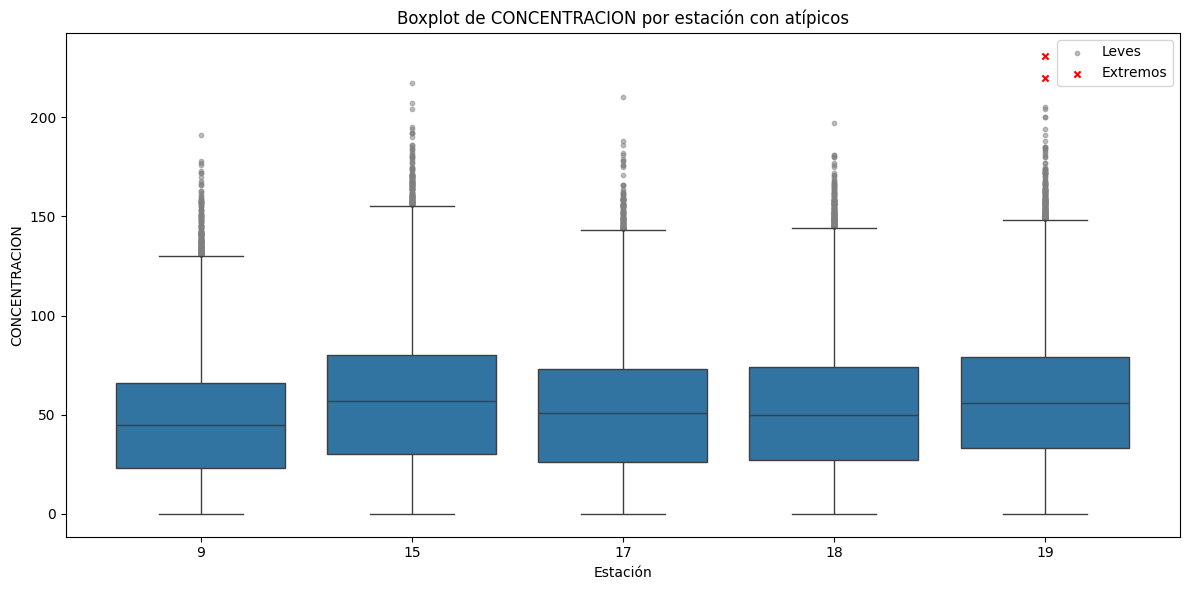

In [ ]:
plt.figure(figsize=(12, 6))
df_plot = df_O3.copy().reset_index()

sns.boxplot(data=df_plot, x='ESTACION', y='CONCENTRACION', showfliers=False)

# Calcular y dibujar outliers leves y extremos manualmente
for i, estacion in enumerate(df_O3['ESTACION'].unique()):
    datos = df_O3[df_O3['ESTACION'] == estacion]['CONCENTRACION'].dropna()
    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1
    mild_min = q1 - 1.5 * iqr
    mild_max = q3 + 1.5 * iqr
    extreme_min = q1 - 3 * iqr
    extreme_max = q3 + 3 * iqr

    # Separar valores leves y extremos
    outliers_leves = datos[(datos < mild_min) | (datos > mild_max)]
    outliers_leves = outliers_leves[(outliers_leves > extreme_min) & (outliers_leves < extreme_max)]

    outliers_extremos = datos[(datos < extreme_min) | (datos > extreme_max)]

    # Leves: círculos grises, extremos: cruces rojas
    plt.scatter([i] * len(outliers_leves), outliers_leves, color='gray', alpha=0.5, s=10, label='Leves' if i == 0 else "")
    plt.scatter([i] * len(outliers_extremos), outliers_extremos, color='red', marker='x', s=20, label='Extremos' if i == 0 else "")

plt.legend()
plt.title("Boxplot de CONCENTRACION por estación con atípicos")
plt.ylabel("CONCENTRACION")
plt.xlabel("Estación")
plt.tight_layout()
plt.show()


## Eliminar días con menos de 18 medidas

In [ ]:
df_O3['original'] = df_O3['CONCENTRACION'].notna().astype(int)

In [ ]:
# Crear un DataFrame vacío para acumular resultados
dfs_procesados = []

# Iterar sobre cada estación única
for estacion in df_O3['ESTACION'].unique():
    # Filtrar por estación
    df_estacion = df_O3[df_O3['ESTACION'] == estacion]

    # Eliminar días incompletos
    df_limpio = eliminar_dias_incompletos(df_estacion)

    # Asegurarse de que el índice esté en datetime y ordenado
    df_limpio = df_limpio.sort_index()
    df_limpio.index = pd.to_datetime(df_limpio.index)

    # Interpolación temporal
    df_limpio['CONCENTRACION'] = df_limpio['CONCENTRACION'].interpolate(method='time')

    # Guardar resultado
    dfs_procesados.append(df_limpio)

# Concatenar todos los resultados
df_O3_interpolado = pd.concat(dfs_procesados)


/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' inste

In [ ]:

dias = pd.date_range(start="2014-01-01", end="2023-12-31", freq="D")
print(len(dias))  # Resultado: 3653


3652


In [ ]:
resumen2 = df_O3_interpolado.groupby("ESTACION").agg(
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())

)

#resumen2["%_nulos"] = 100 * resumen2["registros_nulos"] / resumen2["registros_totales"]
resumen2["dias_faltantes_anteriores"] = resumen["dias_faltantes"]
resumen2["dias_faltantes"] = resumen2.index.to_series().apply(lambda estacion: days_missing(df_O3_interpolado, estacion))
resumen2["%_faltante_total"] = (resumen2["dias_faltantes"] / len(dias))*100

/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-17964

In [ ]:
resumen2.round(2)

,registros_totales,registros_nulos,dias_faltantes_anteriores,dias_faltantes,%_faltante_total
ESTACION,,,,,
9.0,84984,0,77,111,3.04
15.0,84696,0,64,123,3.37
17.0,63624,0,960,1001,27.41
18.0,81768,0,121,245,6.71
19.0,85824,0,53,76,2.08


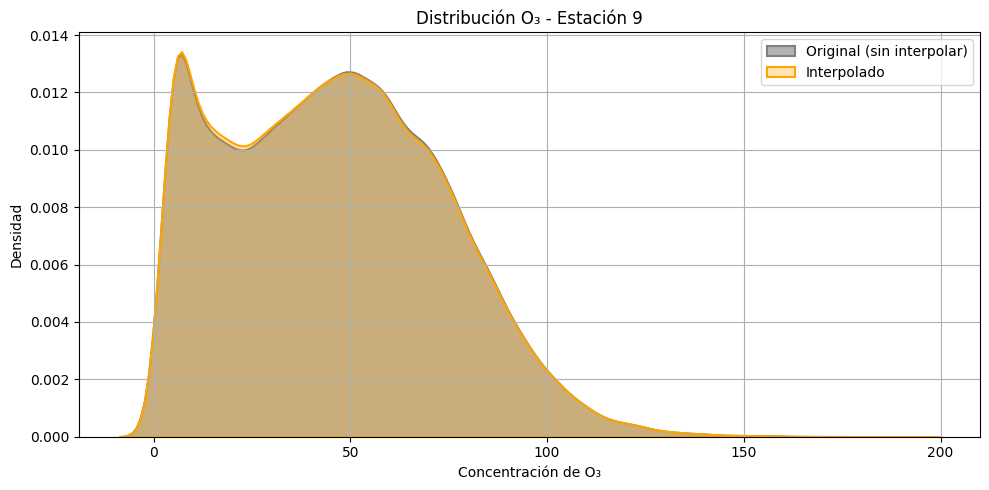

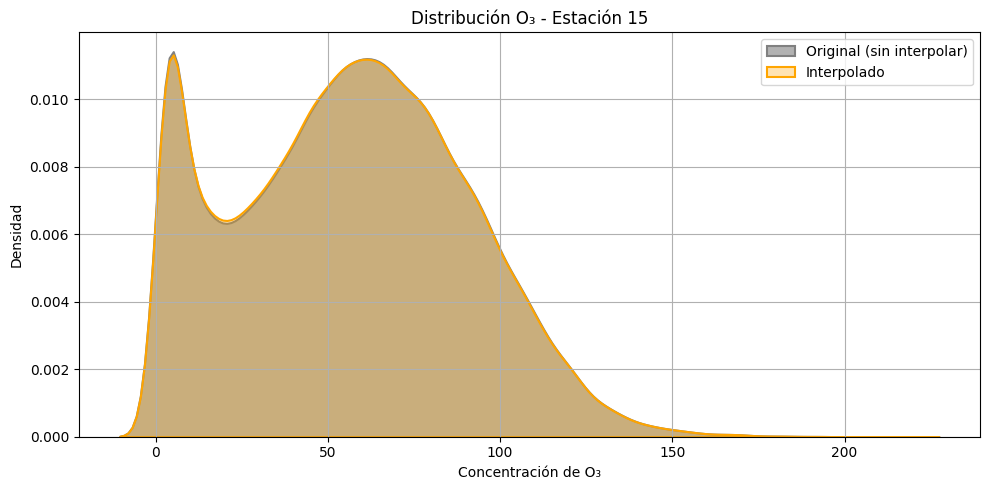

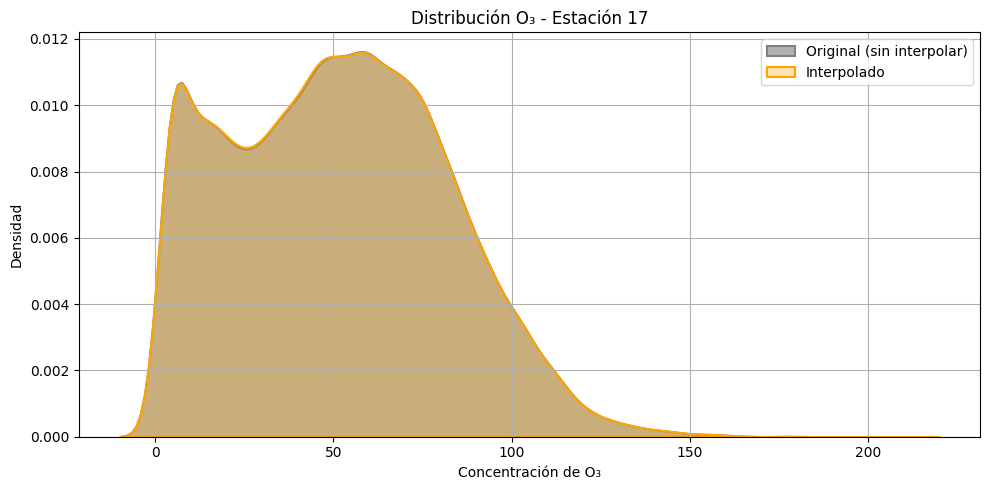

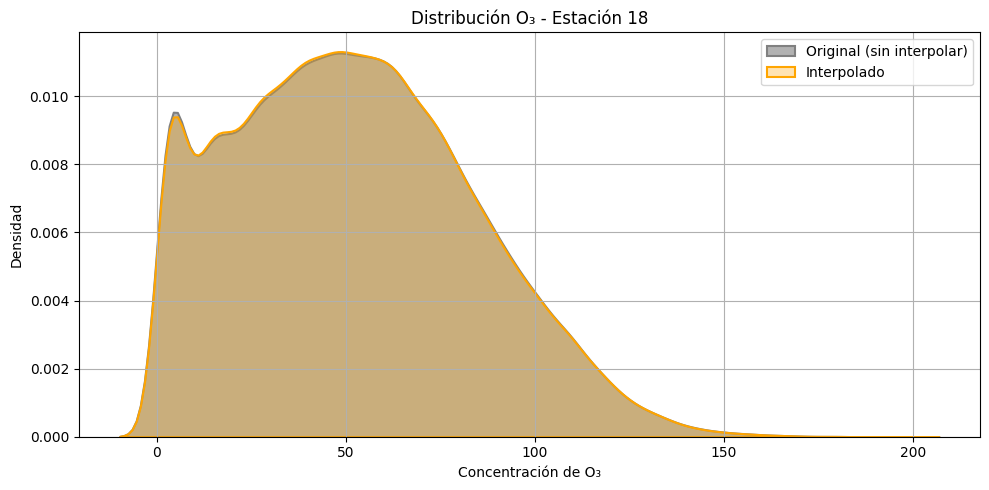

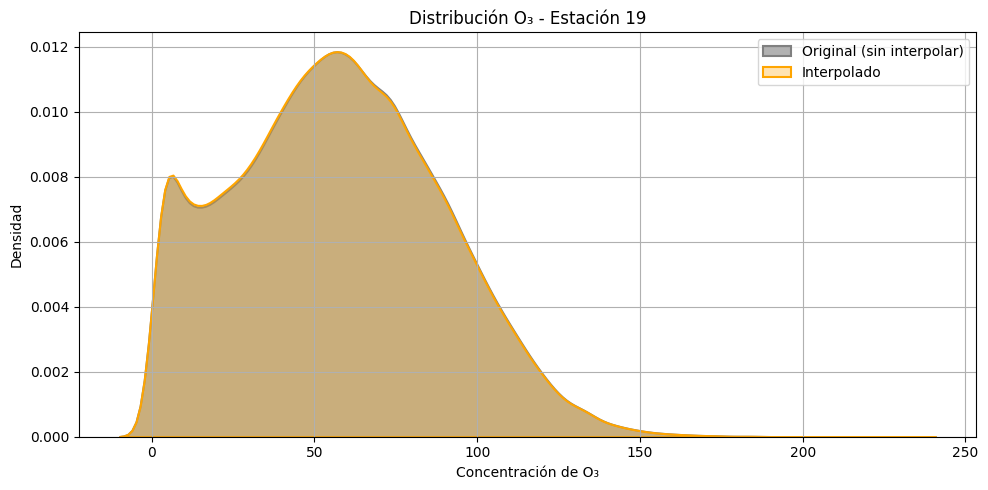

   ESTACION         Tipo      Media  Desviación estándar   P25  P50 (Mediana)  \
1         9  Interpolado  45.720053            27.714524  23.0           45.0   
0         9     Original  45.902364            27.737772  23.0           45.0   
3        15  Interpolado  56.032823            33.490917  30.0           57.0   
2        15     Original  56.094762            33.545456  30.0           57.0   
5        17  Interpolado  51.163087            30.255710  26.0           51.0   
4        17     Original  51.197796            30.284989  26.0           51.0   
7        18  Interpolado  51.859428            31.454503  27.0           50.0   
6        18     Original  51.888068            31.529176  27.0           50.0   
9        19  Interpolado  56.560022            31.827397  32.0           56.0   
8        19     Original  56.731170            31.864402  33.0           56.0   

    P75  
1  66.0  
0  66.0  
3  80.0  
2  80.0  
5  73.0  
4  73.0  
7  74.0  
6  74.0  
9  79.0  
8  79.0 

In [ ]:
# 1. Eliminar nulos de df_O3 (solo donde hay datos reales)
df_original = df_O3[['ESTACION', 'CONCENTRACION']].dropna()

# 2. Copiar df_O3_interpolado asegurando columnas necesarias
df_interpolado = df_O3_interpolado[['ESTACION', 'CONCENTRACION']].copy()

# 3. Inicializar lista para guardar estadísticas
estadisticas = []

# 4. Iterar por cada estación única
for estacion in sorted(df_original['ESTACION'].unique()):
    datos_orig = df_original[df_original['ESTACION'] == estacion]['CONCENTRACION']
    datos_interp = df_interpolado[df_interpolado['ESTACION'] == estacion]['CONCENTRACION']

    # Graficar KDE
    plt.figure(figsize=(10, 5))
    sns.kdeplot(datos_orig, label='Original (sin interpolar)', fill=True, color='gray', alpha=0.6, linewidth=1.5)
    sns.kdeplot(datos_interp, label='Interpolado', fill=True, color='orange', alpha=0.3, linewidth=1.5)
    plt.title(f'Distribución O₃ - Estación {estacion}')
    plt.xlabel('Concentración de O₃')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calcular estadísticas y agregarlas
    for tipo, datos in zip(['Original', 'Interpolado'], [datos_orig, datos_interp]):
        estadisticas.append({
            'ESTACION': estacion,
            'Tipo': tipo,
            'Media': datos.mean(),
            'Desviación estándar': datos.std(),
            'P25': np.percentile(datos, 25),
            'P50 (Mediana)': np.percentile(datos, 50),
            'P75': np.percentile(datos, 75)
        })

# 5. Crear DataFrame resumen
resumen_df = pd.DataFrame(estadisticas)

# 6. Mostrar tabla ordenada
resumen_df = resumen_df.sort_values(['ESTACION', 'Tipo'])
print(resumen_df)


In [ ]:
resumen_df

,ESTACION,Tipo,Media,Desviación estándar,P25,P50 (Mediana),P75
1,9,Interpolado,45.720053,27.714524,23.0,45.0,66.0
0,9,Original,45.902364,27.737772,23.0,45.0,66.0
3,15,Interpolado,56.032823,33.490917,30.0,57.0,80.0
2,15,Original,56.094762,33.545456,30.0,57.0,80.0
5,17,Interpolado,51.163087,30.255710,26.0,51.0,73.0
4,17,Original,51.197796,30.284989,26.0,51.0,73.0
7,18,Interpolado,51.859428,31.454503,27.0,50.0,74.0
6,18,Original,51.888068,31.529176,27.0,50.0,74.0
9,19,Interpolado,56.560022,31.827397,32.0,56.0,79.0
8,19,Original,56.731170,31.864402,33.0,56.0,79.0


In [ ]:
# 1. Eliminar nulos de df_NO2 (solo donde hay datos reales)
df_original = df_O3[['ESTACION', 'CONCENTRACION']].dropna()

# 2. Copiar df_NO2_interpolado asegurando columnas necesarias
df_interpolado = df_O3_interpolado[['ESTACION', 'CONCENTRACION']].copy()

# 3. Inicializar lista para guardar estadísticas
estadisticas = []

# 4. Iterar por cada estación única
for estacion in sorted(df_original['ESTACION'].unique()):
    datos_orig = df_original[df_original['ESTACION'] == estacion]['CONCENTRACION']
    datos_interp = df_interpolado[df_interpolado['ESTACION'] == estacion]['CONCENTRACION']


    datos_2023 = datos_orig[datos_orig.index.year == 2023]
    datos_2023_interp = datos_interp[datos_interp.index.year == 2023]
    # UMA% para NO2
    UMA_percent = 0.18

# Calcular incertidumbre de cada dato observado
    incertidumbres = UMA_percent * datos_2023

# Calcular RMS_U
    RMS_U = np.sqrt(np.mean(incertidumbres**2))
    # Calcular estadísticas y agregarlas
    for tipo, datos in zip(['Original', 'Interpolado'], [datos_2023, datos_2023_interp]):
        estadisticas.append({
            'ESTACION': estacion,
            'Tipo': tipo,
            'RMS_U': RMS_U,
            'Media': datos.mean(),
            'Desviación estándar': datos.std(),
            'P25': np.percentile(datos, 25),
            'P50 (Mediana)': np.percentile(datos, 50),
            'P75': np.percentile(datos, 75)
        })

# 5. Crear DataFrame resumen
resumen_df = pd.DataFrame(estadisticas)

# 6. Mostrar tabla ordenada
resumen_df = resumen_df.sort_values(['ESTACION', 'Tipo'])
print(resumen_df)


   ESTACION         Tipo      RMS_U      Media  Desviación estándar    P25  \
1         9  Interpolado  10.028834  47.547886            28.569339  24.00   
0         9     Original  10.028834  47.834015            28.570132  25.00   
3        15  Interpolado  12.185987  58.345365            34.144537  32.00   
2        15     Original  12.185987  58.435104            34.187040  32.00   
5        17  Interpolado  10.242122  48.204208            29.743778  23.25   
4        17     Original  10.242122  48.432157            29.868792  24.00   
7        18  Interpolado   9.061844  43.160160            25.666731  23.00   
6        18     Original   9.061844  43.296411            25.689930  24.00   
9        19  Interpolado  11.462692  55.642523            30.650689  33.00   
8        19     Original  11.462692  55.814269            30.663076  33.00   

   P50 (Mediana)   P75  
1      46.166667  68.0  
0      47.000000  68.0  
3      59.000000  83.0  
2      59.000000  83.0  
5      47.000000

## Cálculo variables cíclicas

In [ ]:
df_O3_interpolado['hora_sin'] = np.sin(2 * np.pi * df_O3_interpolado['HORA'] / 24)
df_O3_interpolado['hora_cos'] = np.cos(2 * np.pi * df_O3_interpolado['HORA'] / 24)
df_O3_interpolado['dia_semana_sin'] = np.sin(2 * np.pi * df_O3_interpolado['DIA_SEMANA'] / 7)
df_O3_interpolado['dia_semana_cos'] = np.cos(2 * np.pi * df_O3_interpolado['DIA_SEMANA'] / 7)
df_O3_interpolado['mes_sin'] = np.sin(2 * np.pi * df_O3_interpolado['MES'] / 12)
df_O3_interpolado['mes_cos'] = np.cos(2 * np.pi * df_O3_interpolado['MES'] / 12)

df_O3_interpolado.drop(columns=['HORA', 'DIA_SEMANA', 'MES', 'ANNO', 'DIA', 'original'], inplace=True)


In [ ]:
df_O3_interpolado

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2014-01-01 00:00:00,9.0,8.0,0.000000,1.000000,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 01:00:00,9.0,4.0,0.258819,0.965926,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 02:00:00,9.0,3.0,0.500000,0.866025,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 03:00:00,9.0,14.0,0.707107,0.707107,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 04:00:00,9.0,21.0,0.866025,0.500000,0.974928,-0.222521,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.0,7.0,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 20:00:00,19.0,8.0,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 21:00:00,19.0,18.0,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000


In [ ]:
df_O3_interpolado.to_csv('O3_data_final.csv', index=True, index_label='FECHA_HORA')

# Preprocesamiento PM2.5


## Carga y análisis

In [ ]:
df_PM25 = pd.read_csv("PM25.csv", delimiter=";")

In [ ]:
df_PM25 = preparar_dataframe(df_PM25)

In [ ]:
resumen = df_PM25.groupby("ESTACION").agg(
    f_inicio=("CONCENTRACION", lambda x: x.index.min()),
    f_fin=("CONCENTRACION", lambda x: x.index.max()),
    min_con=("CONCENTRACION", "min"),
    max_con=("CONCENTRACION", "max"),
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())
)

# Añadir días faltantes con lambda
resumen["%_nulos"] = 100 * resumen["registros_nulos"] / resumen["registros_totales"]
resumen["dias_faltantes"] = resumen.index.to_series().apply(lambda estacion: days_missing(df_PM25, estacion))

<ipython-input-2-f571cb8ca951>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
<ipython-input-2-f571cb8ca951>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
<ipython-input-2-f571cb8ca951>:5: 

In [ ]:
resumen.round(2)

,f_inicio,f_fin,min_con,max_con,registros_totales,registros_nulos,%_nulos,dias_faltantes
ESTACION,,,,,,,,
9,2021-01-01,2023-12-31 23:00:00,0.0,146.25,25128,342,1.36,48
10,2021-01-01,2023-12-31 23:00:00,0.0,173.16,25920,183,0.71,15
15,2021-01-01,2023-12-31 23:00:00,0.0,241.50,26016,457,1.76,11


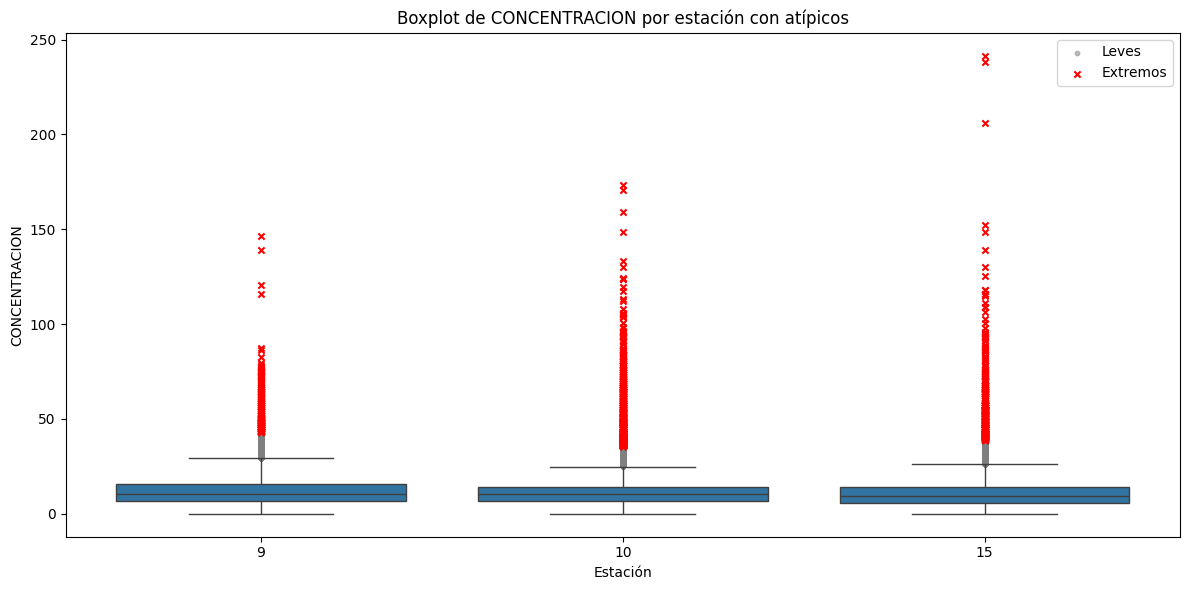

In [ ]:
plt.figure(figsize=(12, 6))
df_plot = df_PM25.copy().reset_index()

sns.boxplot(data=df_plot, x='ESTACION', y='CONCENTRACION', showfliers=False)

# Calcular y dibujar outliers leves y extremos manualmente
for i, estacion in enumerate(df_PM25['ESTACION'].unique()):
    datos = df_PM25[df_PM25['ESTACION'] == estacion]['CONCENTRACION'].dropna()
    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1
    mild_min = q1 - 1.5 * iqr
    mild_max = q3 + 1.5 * iqr
    extreme_min = q1 - 3 * iqr
    extreme_max = q3 + 3 * iqr

    # Separar valores leves y extremos
    outliers_leves = datos[(datos < mild_min) | (datos > mild_max)]
    outliers_leves = outliers_leves[(outliers_leves > extreme_min) & (outliers_leves < extreme_max)]

    outliers_extremos = datos[(datos < extreme_min) | (datos > extreme_max)]

    # Leves: círculos grises, extremos: cruces rojas
    plt.scatter([i] * len(outliers_leves), outliers_leves, color='gray', alpha=0.5, s=10, label='Leves' if i == 0 else "")
    plt.scatter([i] * len(outliers_extremos), outliers_extremos, color='red', marker='x', s=20, label='Extremos' if i == 0 else "")

plt.legend()
plt.title("Boxplot de CONCENTRACION por estación con atípicos")
plt.ylabel("CONCENTRACION")
plt.xlabel("Estación")
plt.tight_layout()
plt.show()


## Eliminar días con menos de 18 medidas

In [ ]:
df_PM25['original'] = df_PM25['CONCENTRACION'].notna().astype(int)

In [ ]:
# Crear un DataFrame vacío para acumular resultados
dfs_procesados = []

# Iterar sobre cada estación única
for estacion in df_PM25['ESTACION'].unique():
    # Filtrar por estación
    df_estacion = df_PM25[df_PM25['ESTACION'] == estacion]

    # Eliminar días incompletos
    df_limpio = eliminar_dias_incompletos(df_estacion)

    # Asegurarse de que el índice esté en datetime y ordenado
    df_limpio = df_limpio.sort_index()
    df_limpio.index = pd.to_datetime(df_limpio.index)

    # Interpolación temporal
    df_limpio['CONCENTRACION'] = df_limpio['CONCENTRACION'].interpolate(method='time')

    # Guardar resultado
    dfs_procesados.append(df_limpio)

# Concatenar todos los resultados
df_PM25_interpolado = pd.concat(dfs_procesados)


<ipython-input-4-0270e46a2045>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
<ipython-input-4-0270e46a2045>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
<ipython-input-4-0270e46a2045>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


In [ ]:

dias = pd.date_range(start="2021-01-01", end="2023-12-31", freq="D")
print(len(dias))  # Resultado: 3653


1095


In [ ]:
resumen2 = df_PM25_interpolado.groupby("ESTACION").agg(
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())

)

#resumen2["%_nulos"] = 100 * resumen2["registros_nulos"] / resumen2["registros_totales"]
resumen2["dias_faltantes_anteriores"] = resumen["dias_faltantes"]
resumen2["dias_faltantes"] = resumen2.index.to_series().apply(lambda estacion: days_missing(df_PM25_interpolado, estacion))
resumen2["%_faltante_total"] = (resumen2["dias_faltantes"] / len(dias))*100

<ipython-input-2-f571cb8ca951>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
<ipython-input-2-f571cb8ca951>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
<ipython-input-2-f571cb8ca951>:5: 

In [ ]:
resumen2.round(2)

,registros_totales,registros_nulos,dias_faltantes_anteriores,dias_faltantes,%_faltante_total
ESTACION,,,,,
9.0,24720,0,48,65,5.94
10.0,25680,0,15,25,2.28
15.0,25440,0,11,35,3.20


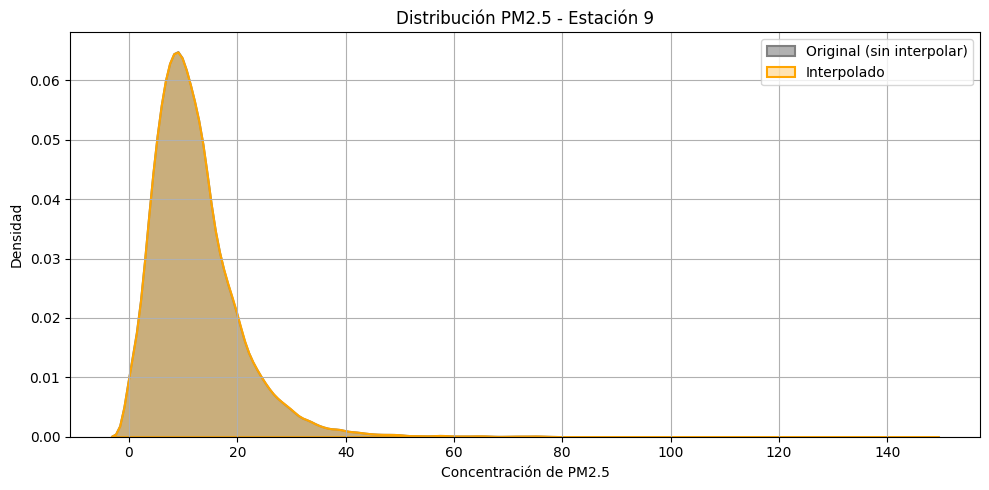

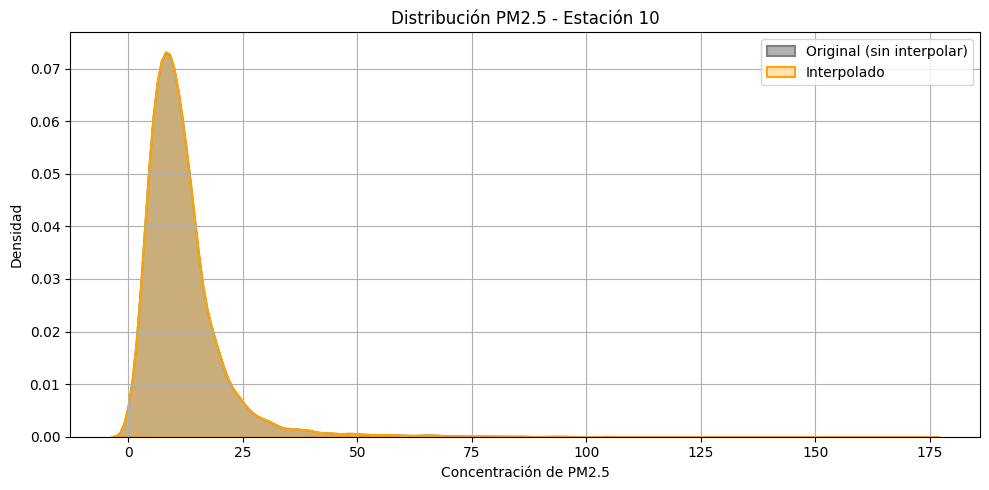

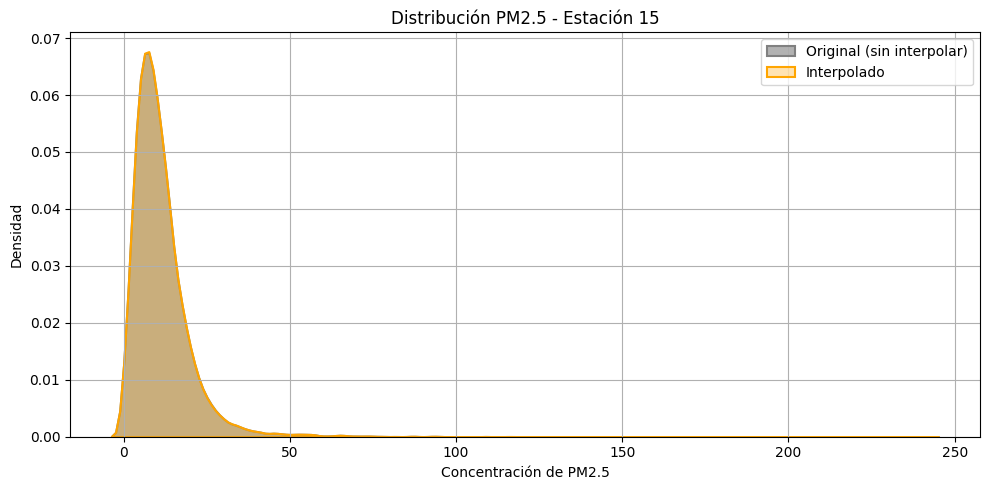

   ESTACION         Tipo      Media  Desviación estándar   P25  P50 (Mediana)  \
1         9  Interpolado  12.237272             8.193715  6.90          10.60   
0         9     Original  12.224464             8.196354  6.90          10.60   
3        10  Interpolado  11.941521             9.471363  6.90          10.35   
2        10     Original  11.932902             9.472446  6.90          10.35   
5        15  Interpolado  11.288370             9.338378  5.75           9.36   
4        15     Original  11.282007             9.328966  5.75           9.36   

     P75  
1  15.90  
0  15.90  
3  14.04  
2  14.04  
5  14.04  
4  14.04  


In [ ]:
# 1. Eliminar nulos de df_PM25 (solo donde hay datos reales)
df_original = df_PM25[['ESTACION', 'CONCENTRACION']].dropna()

# 2. Copiar df_PM25_interpolado asegurando columnas necesarias
df_interpolado = df_PM25_interpolado[['ESTACION', 'CONCENTRACION']].copy()

# 3. Inicializar lista para guardar estadísticas
estadisticas = []

# 4. Iterar por cada estación única
for estacion in sorted(df_original['ESTACION'].unique()):
    datos_orig = df_original[df_original['ESTACION'] == estacion]['CONCENTRACION']
    datos_interp = df_interpolado[df_interpolado['ESTACION'] == estacion]['CONCENTRACION']

    # Graficar KDE
    plt.figure(figsize=(10, 5))
    sns.kdeplot(datos_orig, label='Original (sin interpolar)', fill=True, color='gray', alpha=0.6, linewidth=1.5)
    sns.kdeplot(datos_interp, label='Interpolado', fill=True, color='orange', alpha=0.3, linewidth=1.5)
    plt.title(f'Distribución PM2.5 - Estación {estacion}')
    plt.xlabel('Concentración de PM2.5')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calcular estadísticas y agregarlas
    for tipo, datos in zip(['Original', 'Interpolado'], [datos_orig, datos_interp]):
        estadisticas.append({
            'ESTACION': estacion,
            'Tipo': tipo,
            'Media': datos.mean(),
            'Desviación estándar': datos.std(),
            'P25': np.percentile(datos, 25),
            'P50 (Mediana)': np.percentile(datos, 50),
            'P75': np.percentile(datos, 75)
        })

# 5. Crear DataFrame resumen
resumen_df = pd.DataFrame(estadisticas)

# 6. Mostrar tabla ordenada
resumen_df = resumen_df.sort_values(['ESTACION', 'Tipo'])
print(resumen_df)


In [ ]:
resumen_df

,ESTACION,Tipo,Media,Desviación estándar,P25,P50 (Mediana),P75
1,9,Interpolado,12.237272,8.193715,6.90,10.60,15.90
0,9,Original,12.224464,8.196354,6.90,10.60,15.90
3,10,Interpolado,11.941521,9.471363,6.90,10.35,14.04
2,10,Original,11.932902,9.472446,6.90,10.35,14.04
5,15,Interpolado,11.288370,9.338378,5.75,9.36,14.04
4,15,Original,11.282007,9.328966,5.75,9.36,14.04


## Cálculo variables cíclicas

In [ ]:
df_PM25_interpolado['hora_sin'] = np.sin(2 * np.pi * df_PM25_interpolado['HORA'] / 24)
df_PM25_interpolado['hora_cos'] = np.cos(2 * np.pi * df_PM25_interpolado['HORA'] / 24)
df_PM25_interpolado['dia_semana_sin'] = np.sin(2 * np.pi * df_PM25_interpolado['DIA_SEMANA'] / 7)
df_PM25_interpolado['dia_semana_cos'] = np.cos(2 * np.pi * df_PM25_interpolado['DIA_SEMANA'] / 7)
df_PM25_interpolado['mes_sin'] = np.sin(2 * np.pi * df_PM25_interpolado['MES'] / 12)
df_PM25_interpolado['mes_cos'] = np.cos(2 * np.pi * df_PM25_interpolado['MES'] / 12)

df_PM25_interpolado.drop(columns=['HORA', 'DIA_SEMANA', 'MES', 'ANNO', 'DIA', 'original'], inplace=True)


In [ ]:
df_PM25_interpolado

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2021-01-01 00:00:00,9.0,13.78,0.000000,1.000000,-0.433884,-0.900969,5.000000e-01,0.866025
2021-01-01 01:00:00,9.0,12.72,0.258819,0.965926,-0.433884,-0.900969,5.000000e-01,0.866025
2021-01-01 02:00:00,9.0,9.54,0.500000,0.866025,-0.433884,-0.900969,5.000000e-01,0.866025
2021-01-01 03:00:00,9.0,7.42,0.707107,0.707107,-0.433884,-0.900969,5.000000e-01,0.866025
2021-01-01 04:00:00,9.0,4.24,0.866025,0.500000,-0.433884,-0.900969,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,15.0,33.35,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 20:00:00,15.0,40.25,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 21:00:00,15.0,40.25,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000


In [ ]:
df_PM25_interpolado.to_csv('PM25_data_final.csv', index=True, index_label='FECHA_HORA')

# Preprocesamiento PM10


## Carga y análisis

In [ ]:
df_PM10 = pd.read_csv("PM10.csv", delimiter=";")

In [ ]:
df_PM10 = preparar_dataframe(df_PM10)

In [ ]:
df_PM10.head(200)

,ESTACION,CONCENTRACION,HORA,DIA_SEMANA,DIA,MES,ANNO
FECHA_HORA,,,,,,,
2015-12-31 00:00:00,9,NaN,0,3,31,12,2015
2015-12-31 00:00:00,15,NaN,0,3,31,12,2015
2015-12-31 00:00:00,16,NaN,0,3,31,12,2015
2015-12-31 00:00:00,18,NaN,0,3,31,12,2015
2015-12-31 01:00:00,9,NaN,1,3,31,12,2015
...,...,...,...,...,...,...,...
2016-01-02 00:00:00,15,"14,25",0,5,2,1,2016
2016-01-02 01:00:00,15,"12,35",1,5,2,1,2016
2016-01-02 01:00:00,16,"9,2",1,5,2,1,2016


In [ ]:
df_PM10['CONCENTRACION'] = df_PM10['CONCENTRACION'].str.replace(',', '.').astype(float)

In [ ]:
resumen = df_PM10.groupby("ESTACION").agg(
    f_inicio=("CONCENTRACION", lambda x: x.index.min()),
    f_fin=("CONCENTRACION", lambda x: x.index.max()),
    min_con=("CONCENTRACION", "min"),
    max_con=("CONCENTRACION", "max"),
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())
)

# Añadir días faltantes con lambda
resumen["%_nulos"] = 100 * resumen["registros_nulos"] / resumen["registros_totales"]
resumen["dias_faltantes"] = resumen.index.to_series().apply(lambda estacion: days_missing(df_PM10, estacion))

/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-17964

In [ ]:
resumen.round(2)

,f_inicio,f_fin,min_con,max_con,registros_totales,registros_nulos,%_nulos,dias_faltantes
ESTACION,,,,,,,,
9,2015-12-31,2023-12-31 23:00:00,0.0,794.58,60000,1821,3.04,423
15,2015-12-31,2023-12-31 23:00:00,0.0,708.40,57672,1528,2.65,520
16,2015-12-31,2023-12-31 23:00:00,0.0,696.51,53280,489,0.92,703
18,2015-12-31,2023-12-31 23:00:00,0.0,753.19,34536,761,2.20,1484


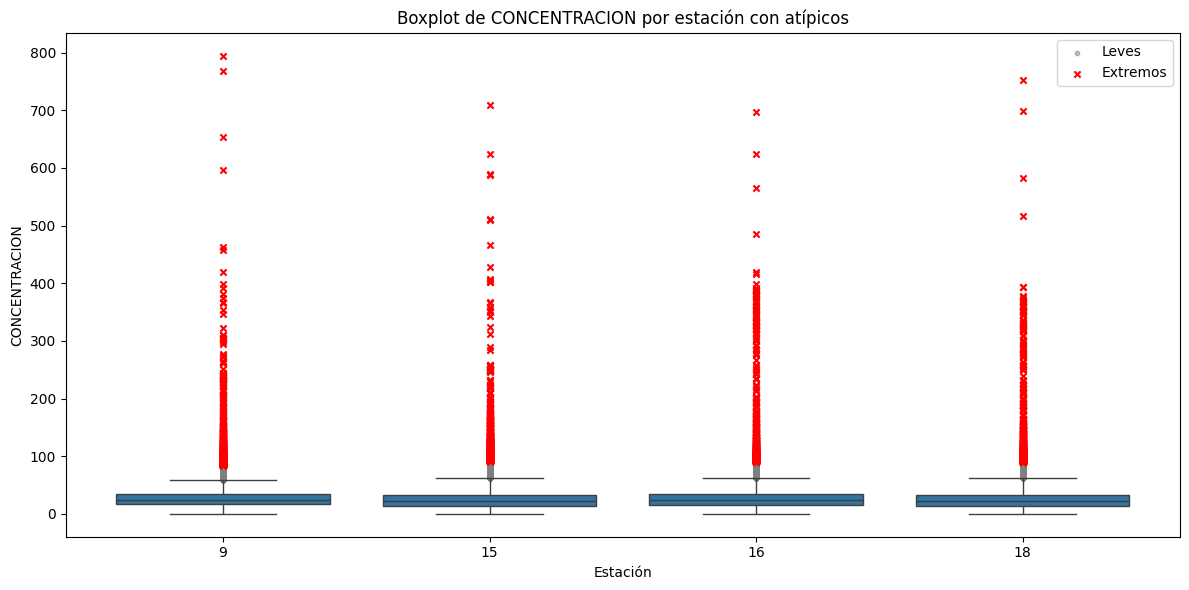

In [ ]:
plt.figure(figsize=(12, 6))
df_plot = df_PM10.copy().reset_index()

sns.boxplot(data=df_plot, x='ESTACION', y='CONCENTRACION', showfliers=False)

# Calcular y dibujar outliers leves y extremos manualmente
for i, estacion in enumerate(df_PM10['ESTACION'].unique()):
    datos = df_PM10[df_PM10['ESTACION'] == estacion]['CONCENTRACION'].dropna()
    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1
    mild_min = q1 - 1.5 * iqr
    mild_max = q3 + 1.5 * iqr
    extreme_min = q1 - 3 * iqr
    extreme_max = q3 + 3 * iqr

    # Separar valores leves y extremos
    outliers_leves = datos[(datos < mild_min) | (datos > mild_max)]
    outliers_leves = outliers_leves[(outliers_leves > extreme_min) & (outliers_leves < extreme_max)]

    outliers_extremos = datos[(datos < extreme_min) | (datos > extreme_max)]

    # Leves: círculos grises, extremos: cruces rojas
    plt.scatter([i] * len(outliers_leves), outliers_leves, color='gray', alpha=0.5, s=10, label='Leves' if i == 0 else "")
    plt.scatter([i] * len(outliers_extremos), outliers_extremos, color='red', marker='x', s=20, label='Extremos' if i == 0 else "")

plt.legend()
plt.title("Boxplot de CONCENTRACION por estación con atípicos")
plt.ylabel("CONCENTRACION")
plt.xlabel("Estación")
plt.tight_layout()
plt.show()


## Eliminar días con menos de 18 medidas

In [ ]:
df_PM10['original'] = df_PM10['CONCENTRACION'].notna().astype(int)

In [ ]:
# Crear un DataFrame vacío para acumular resultados
dfs_procesados = []

# Iterar sobre cada estación única
for estacion in df_PM10['ESTACION'].unique():
    # Filtrar por estación
    df_estacion = df_PM10[df_PM10['ESTACION'] == estacion]

    # Eliminar días incompletos
    df_limpio = eliminar_dias_incompletos(df_estacion)

    # Asegurarse de que el índice esté en datetime y ordenado
    df_limpio = df_limpio.sort_index()
    df_limpio.index = pd.to_datetime(df_limpio.index)

    # Interpolación temporal
    df_limpio['CONCENTRACION'] = df_limpio['CONCENTRACION'].interpolate(method='time')

    # Guardar resultado
    dfs_procesados.append(df_limpio)

# Concatenar todos los resultados
df_PM10_interpolado = pd.concat(dfs_procesados)


/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
/tmp/ipython-input-4-2607102127.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


In [ ]:

dias = pd.date_range(start="2015-12-31", end="2023-12-31", freq="D")
print(len(dias))


2923


In [ ]:
resumen2 = df_PM10_interpolado.groupby("ESTACION").agg(
    registros_totales=("CONCENTRACION", "size"),
    registros_nulos=("CONCENTRACION", lambda x: x.isna().sum())

)

#resumen2["%_nulos"] = 100 * resumen2["registros_nulos"] / resumen2["registros_totales"]
resumen2["dias_faltantes_anteriores"] = resumen["dias_faltantes"]
resumen2["dias_faltantes"] = resumen2.index.to_series().apply(lambda estacion: days_missing(df_PM10_interpolado, estacion))
resumen2["%_faltante_total"] = (resumen2["dias_faltantes"] / len(dias))*100

/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-1796481761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_estacion.loc[:, "FECHA"] = pd.to_datetime(dataframe_estacion[['ANNO', 'MES', 'DIA']].rename(columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day'}))
/tmp/ipython-input-2-17964

In [ ]:
resumen2.round(2)

,registros_totales,registros_nulos,dias_faltantes_anteriores,dias_faltantes,%_faltante_total
ESTACION,,,,,
9.0,58728,0,423,475,16.25
15.0,55968,0,520,590,20.18
16.0,52776,0,703,723,24.73
18.0,33792,0,1484,1514,51.80


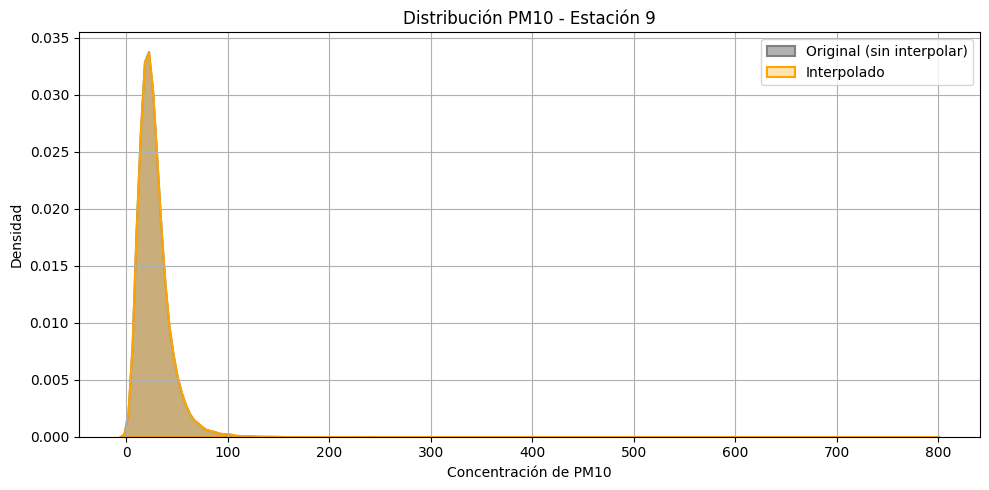

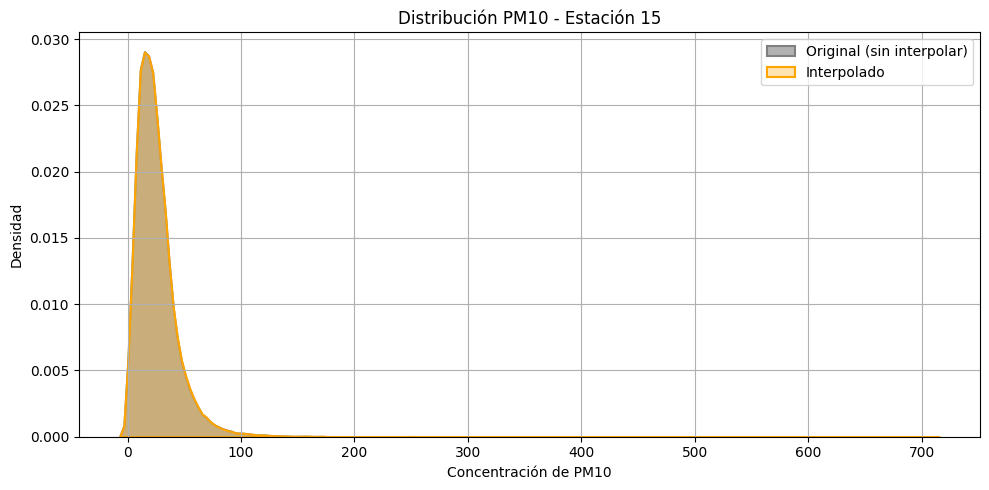

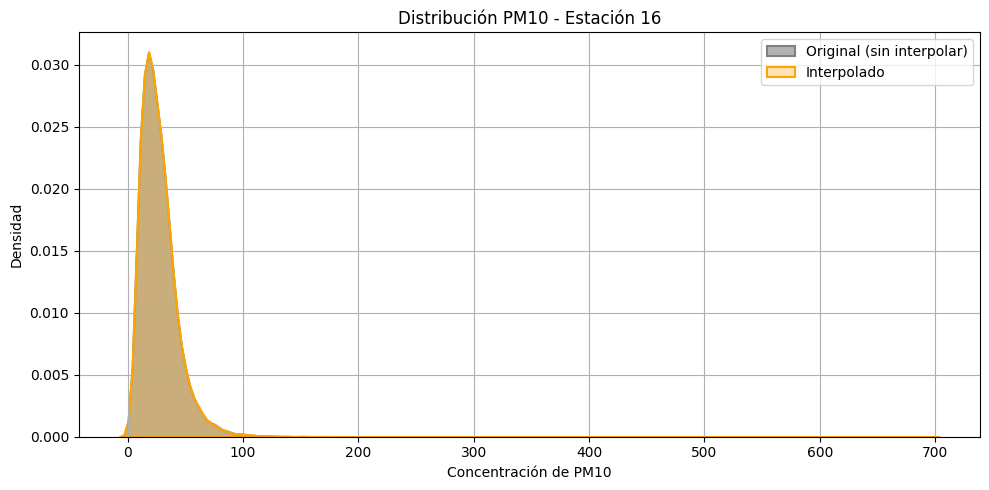

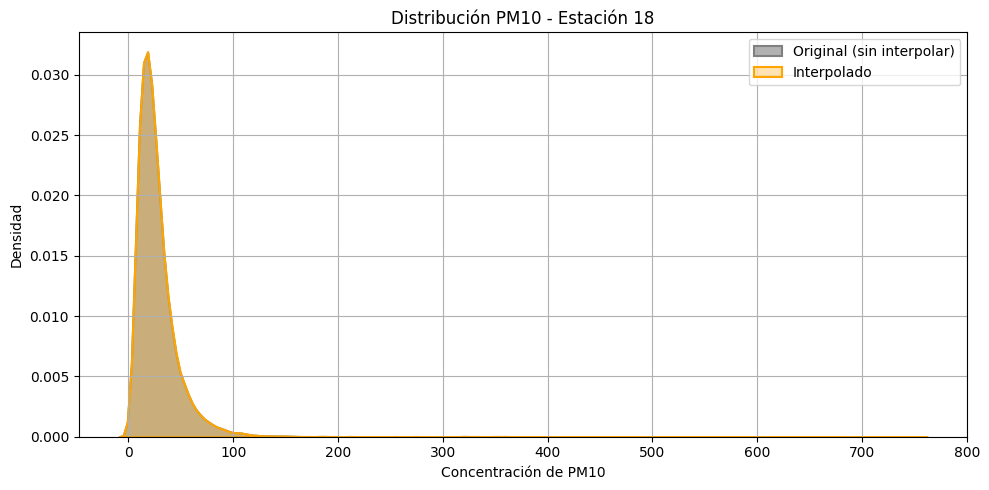

   ESTACION         Tipo      Media  Desviación estándar    P25  \
1         9  Interpolado  27.577178            18.807010  16.96   
0         9     Original  27.570976            18.834855  16.80   
3        15  Interpolado  25.540582            20.428597  13.30   
2        15     Original  25.479854            20.418689  12.76   
5        16  Interpolado  27.483659            20.199245  15.96   
4        16     Original  27.469923            20.202988  15.90   
7        18  Interpolado  27.430823            23.854986  14.25   
6        18     Original  27.400283            23.887152  14.25   

   P50 (Mediana)    P75  
1          24.15  33.75  
0          24.15  33.75  
3          21.85  32.48  
2          21.84  32.48  
5          23.98  34.56  
4          23.98  34.56  
7          22.04  33.64  
6          22.04  33.25  


In [ ]:
# 1. Eliminar nulos de df_PM25 (solo donde hay datos reales)
df_original = df_PM10[['ESTACION', 'CONCENTRACION']].dropna()

# 2. Copiar df_PM25_interpolado asegurando columnas necesarias
df_interpolado = df_PM10_interpolado[['ESTACION', 'CONCENTRACION']].copy()

# 3. Inicializar lista para guardar estadísticas
estadisticas = []

# 4. Iterar por cada estación única
for estacion in sorted(df_original['ESTACION'].unique()):
    datos_orig = df_original[df_original['ESTACION'] == estacion]['CONCENTRACION']
    datos_interp = df_interpolado[df_interpolado['ESTACION'] == estacion]['CONCENTRACION']

    # Graficar KDE
    plt.figure(figsize=(10, 5))
    sns.kdeplot(datos_orig, label='Original (sin interpolar)', fill=True, color='gray', alpha=0.6, linewidth=1.5)
    sns.kdeplot(datos_interp, label='Interpolado', fill=True, color='orange', alpha=0.3, linewidth=1.5)
    plt.title(f'Distribución PM10 - Estación {estacion}')
    plt.xlabel('Concentración de PM10')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calcular estadísticas y agregarlas
    for tipo, datos in zip(['Original', 'Interpolado'], [datos_orig, datos_interp]):
        estadisticas.append({
            'ESTACION': estacion,
            'Tipo': tipo,
            'Media': datos.mean(),
            'Desviación estándar': datos.std(),
            'P25': np.percentile(datos, 25),
            'P50 (Mediana)': np.percentile(datos, 50),
            'P75': np.percentile(datos, 75)
        })

# 5. Crear DataFrame resumen
resumen_df = pd.DataFrame(estadisticas)

# 6. Mostrar tabla ordenada
resumen_df = resumen_df.sort_values(['ESTACION', 'Tipo'])
print(resumen_df)


In [ ]:
resumen_df

,ESTACION,Tipo,Media,Desviación estándar,P25,P50 (Mediana),P75
1,9,Interpolado,27.577178,18.807010,16.96,24.15,33.75
0,9,Original,27.570976,18.834855,16.80,24.15,33.75
3,15,Interpolado,25.540582,20.428597,13.30,21.85,32.48
2,15,Original,25.479854,20.418689,12.76,21.84,32.48
5,16,Interpolado,27.483659,20.199245,15.96,23.98,34.56
4,16,Original,27.469923,20.202988,15.90,23.98,34.56
7,18,Interpolado,27.430823,23.854986,14.25,22.04,33.64
6,18,Original,27.400283,23.887152,14.25,22.04,33.25


In [ ]:
# 1. Eliminar nulos de df_NO2 (solo donde hay datos reales)
df_original = df_PM10[['ESTACION', 'CONCENTRACION']].dropna()

# 2. Copiar df_NO2_interpolado asegurando columnas necesarias
df_interpolado = df_PM10_interpolado[['ESTACION', 'CONCENTRACION']].copy()

# 3. Inicializar lista para guardar estadísticas
estadisticas = []

# 4. Iterar por cada estación única
for estacion in sorted(df_original['ESTACION'].unique()):
    datos_orig = df_original[df_original['ESTACION'] == estacion]['CONCENTRACION']
    datos_interp = df_interpolado[df_interpolado['ESTACION'] == estacion]['CONCENTRACION']


    datos_2023 = datos_orig[datos_orig.index.year == 2023]
    datos_2023_interp = datos_interp[datos_interp.index.year == 2023]
    # UMA% para NO2
    UMA_percent = 0.25

# Calcular incertidumbre de cada dato observado
    incertidumbres = UMA_percent * datos_2023

# Calcular RMS_U
    RMS_U = np.sqrt(np.mean(incertidumbres**2))
    # Calcular estadísticas y agregarlas
    for tipo, datos in zip(['Original', 'Interpolado'], [datos_2023, datos_2023_interp]):
        estadisticas.append({
            'ESTACION': estacion,
            'Tipo': tipo,
            'RMS_U': RMS_U,
            'Media': datos.mean(),
            'Desviación estándar': datos.std(),
            'P25': np.percentile(datos, 25),
            'P50 (Mediana)': np.percentile(datos, 50),
            'P75': np.percentile(datos, 75)
        })

# 5. Crear DataFrame resumen
resumen_df = pd.DataFrame(estadisticas)

# 6. Mostrar tabla ordenada
resumen_df = resumen_df.sort_values(['ESTACION', 'Tipo'])
print(resumen_df)


   ESTACION         Tipo     RMS_U      Media  Desviación estándar    P25  \
1         9  Interpolado  7.606059  25.922602            15.899304  15.75   
0         9     Original  7.606059  25.941209            15.897124  15.75   
3        15  Interpolado  7.623643  23.897715            19.245528  12.10   
2        15     Original  7.623643  23.734473            19.147765  12.10   
5        16  Interpolado  7.234330  24.761883            14.973475  14.84   
4        16     Original  7.234330  24.753255            14.989012  14.84   
7        18  Interpolado  7.935924  25.617409            18.729324  13.78   
6        18     Original  7.935924  25.617769            18.746533  13.78   

   P50 (Mediana)    P75  
1          22.05  32.55  
0          23.10  32.55  
3          19.36  30.25  
2          19.36  30.25  
5          21.20  30.74  
4          21.20  30.74  
7          21.20  30.74  
6          21.20  30.74  


## Cálculo variables cíclicas

In [ ]:
df_PM10_interpolado['hora_sin'] = np.sin(2 * np.pi * df_PM10_interpolado['HORA'] / 24)
df_PM10_interpolado['hora_cos'] = np.cos(2 * np.pi * df_PM10_interpolado['HORA'] / 24)
df_PM10_interpolado['dia_semana_sin'] = np.sin(2 * np.pi * df_PM10_interpolado['DIA_SEMANA'] / 7)
df_PM10_interpolado['dia_semana_cos'] = np.cos(2 * np.pi * df_PM10_interpolado['DIA_SEMANA'] / 7)
df_PM10_interpolado['mes_sin'] = np.sin(2 * np.pi * df_PM10_interpolado['MES'] / 12)
df_PM10_interpolado['mes_cos'] = np.cos(2 * np.pi * df_PM10_interpolado['MES'] / 12)

df_PM10_interpolado.drop(columns=['HORA', 'DIA_SEMANA', 'MES', 'ANNO', 'DIA', 'original'], inplace=True)


In [ ]:
df_PM10_interpolado

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2016-01-01 00:00:00,9.0,27.88,0.000000,1.000000,-0.433884,-0.900969,5.000000e-01,0.866025
2016-01-01 01:00:00,9.0,36.90,0.258819,0.965926,-0.433884,-0.900969,5.000000e-01,0.866025
2016-01-01 02:00:00,9.0,27.06,0.500000,0.866025,-0.433884,-0.900969,5.000000e-01,0.866025
2016-01-01 03:00:00,9.0,18.04,0.707107,0.707107,-0.433884,-0.900969,5.000000e-01,0.866025
2016-01-01 04:00:00,9.0,16.40,0.866025,0.500000,-0.433884,-0.900969,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,18.0,27.56,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 20:00:00,18.0,31.80,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 21:00:00,18.0,38.16,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000


In [ ]:
df_PM10_interpolado.to_csv('PM10_data_final.csv', index=True, index_label='FECHA_HORA')

# Cargar y preprocesar clima

In [ ]:
pip install meteostat

In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly

# Set time period
start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31, 23, 59)

# Get hourly data
data = Hourly('08391', start, end)
data = data.fetch()

# Print DataFrame
print(data)

                     temp  dwpt   rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                            
2014-01-01 00:00:00  11.7   9.1   87.0  <NA>  <NA>   60.0   1.8  <NA>  1024.1   
2014-01-01 03:00:00  11.1   9.5   92.0  <NA>  <NA>  100.0   1.8  <NA>  1023.1   
2014-01-01 04:00:00  11.0   9.8   94.0  <NA>  <NA>    0.0   0.0  <NA>    <NA>   
2014-01-01 05:00:00  11.0  11.0  100.0  <NA>  <NA>   40.0   3.6  <NA>    <NA>   
2014-01-01 06:00:00  10.9  10.3   97.0  <NA>  <NA>    0.0   0.0  <NA>  1022.2   
...                   ...   ...    ...   ...   ...    ...   ...   ...     ...   
2023-12-31 19:00:00   9.5   9.5  100.0   0.0  <NA>   30.0   7.6  <NA>  1020.9   
2023-12-31 20:00:00   9.3   9.3  100.0   0.0  <NA>   10.0   3.6  <NA>  1021.1   
2023-12-31 21:00:00   7.9   7.9  100.0   0.0  <NA>  360.0   5.4  <NA>  1021.3   
2023-12-31 22:00:00   7.7   7.7  100.0   0.0  <NA>   30.0   1.8  <NA>  1021.4   
2023-12-31 23:00:00   8.8   

In [ ]:

columnas = ['temp', 'dwpt', 'rhum', 'wdir', 'wspd','prcp']
data_filtrada = data[columnas]
print(data_filtrada.head())

                     temp  dwpt   rhum   wdir  wspd  prcp
time                                                     
2014-01-01 00:00:00  11.7   9.1   87.0   60.0   1.8  <NA>
2014-01-01 03:00:00  11.1   9.5   92.0  100.0   1.8  <NA>
2014-01-01 04:00:00  11.0   9.8   94.0    0.0   0.0  <NA>
2014-01-01 05:00:00  11.0  11.0  100.0   40.0   3.6  <NA>
2014-01-01 06:00:00  10.9  10.3   97.0    0.0   0.0  <NA>


In [ ]:
print(data_filtrada.describe())


            temp       dwpt       rhum        wdir       wspd      prcp
count    86736.0    86718.0    86718.0     85713.0    86762.0   14023.0
mean   19.376996  12.001511  63.117161  168.267742  10.462671  0.035649
std     8.034345   5.210214  23.832846   105.17326   7.406321  0.277511
min         -1.1      -10.4        2.0         0.0        0.0       0.0
25%         13.5        8.4       44.0        60.0        5.4       0.0
50%         18.6       12.4       65.0       200.0        9.4       0.0
75%         24.7       15.9       84.0       240.0       14.8       0.0
max         44.5       27.6      100.0       360.0       59.4       8.1


In [ ]:
data_filtrada['prcp'] = data_filtrada['prcp'].fillna(0)
data_filtrada['prcp'] = (data_filtrada['prcp'] > 0).astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print(data_filtrada.describe())

            temp       dwpt       rhum        wdir       wspd          prcp
count    86736.0    86718.0    86718.0     85713.0    86762.0  86764.000000
mean   19.376996  12.001511  63.117161  168.267742  10.462671      0.007238
std     8.034345   5.210214  23.832846   105.17326   7.406321      0.084769
min         -1.1      -10.4        2.0         0.0        0.0      0.000000
25%         13.5        8.4       44.0        60.0        5.4      0.000000
50%         18.6       12.4       65.0       200.0        9.4      0.000000
75%         24.7       15.9       84.0       240.0       14.8      0.000000
max         44.5       27.6      100.0       360.0       59.4      1.000000


In [ ]:
def eliminar_dias_incompletos(df, columnas_relevantes, umbral=18):
    # Asegurar índice datetime y ordenado
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Crear rango horario completo
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
    df_full = df.reindex(full_range)
    df_full.index.name = 'time'

    # Filtrar filas completas (sin NaN en columnas relevantes)
    df_validas = df_full[columnas_relevantes].dropna()

    # Agrupar por día usando el índice de df_validas
    valid_counts = df_validas.groupby(df_validas.index.normalize()).size()

    # Identificar días con menos de 'umbral' registros
    dias_incompletos = valid_counts[valid_counts < umbral].index

    # Eliminar todas las horas de esos días del df_full
    df_filtrado = df_full[~df_full.index.normalize().isin(dias_incompletos)]

    return df_filtrado


In [ ]:
data_limpia = eliminar_dias_incompletos(data_filtrada[columnas], columnas_relevantes=columnas)
data_limpia.describe()

,temp,dwpt,rhum,wdir,wspd,prcp
count,86125.0,86108.0,86108.0,85245.0,86132.0,86134.000000
mean,19.41766,12.024489,63.02728,168.60183,10.504643,0.007291
std,8.031278,5.209725,23.825628,105.04911,7.40336,0.085076
min,-1.1,-10.4,2.0,0.0,0.0,0.000000
25%,13.5,8.4,44.0,60.0,5.4,0.000000
50%,18.7,12.4,65.0,200.0,9.4,0.000000
75%,24.7,15.9,84.0,240.0,14.8,0.000000
max,44.5,27.6,100.0,360.0,59.4,1.000000


In [ ]:
data_limpia.isna().sum()


,0
temp,827
dwpt,844
rhum,844
wdir,1707
wspd,820
prcp,818


In [ ]:
def interpolar_variables(df, col_wdir='wdir'):
    df = df.copy()

    # Separar columnas
    columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

    if col_wdir not in columnas_numericas:
        raise ValueError(f"La columna '{col_wdir}' no está en el DataFrame o no es numérica.")

    columnas_a_interpolar = [col for col in columnas_numericas if col != col_wdir]

    # Interpolación temporal para las demás variables
    df[columnas_a_interpolar] = df[columnas_a_interpolar].interpolate(method='time', limit_direction='both')

    # Interpolación trigonométrica para wdir
    wdir_rad = np.deg2rad(df[col_wdir])
    df['wdir_sin'] = np.sin(wdir_rad)
    df['wdir_cos'] = np.cos(wdir_rad)

    # Interpolar senos y cosenos
    df['wdir_sin'] = df['wdir_sin'].interpolate(method='time', limit_direction='both')
    df['wdir_cos'] = df['wdir_cos'].interpolate(method='time', limit_direction='both')
    df.drop(columns=['wdir'], inplace=True)

    return df


In [ ]:
data_interpolada = interpolar_variables(data_limpia, col_wdir='wdir')
data_interpolada.describe()

,temp,dwpt,rhum,wspd,prcp,wdir_sin,wdir_cos
count,86952.0,86952.0,86952.0,86952.0,86952.000000,86952.0,86952.0
mean,19.369529,12.007537,63.189852,10.476241,0.007222,-0.054593,-0.0085
std,8.027028,5.206988,23.813298,7.399475,0.084678,0.671547,0.735386
min,-1.1,-10.4,2.0,0.0,0.000000,-1.0,-1.0
25%,13.5,8.4,44.0,5.4,0.000000,-0.642788,-0.766044
50%,18.6,12.4,66.0,9.4,0.000000,-0.0,-0.0
75%,24.7,15.9,84.0,14.8,0.000000,0.642788,0.766044
max,44.5,27.6,100.0,59.4,1.000000,1.0,1.0


In [ ]:
data_interpolada['rhum'] = data_interpolada['rhum'].clip(upper=100)
data_interpolada.describe()
data_final = data_interpolada.round(1)
data_final.describe()

,temp,dwpt,rhum,wspd,prcp,wdir_sin,wdir_cos
count,86952.0,86952.0,86952.0,86952.0,86952.000000,86952.0,86952.0
mean,19.369523,12.007539,63.189852,10.476242,0.007222,-0.052267,-0.011494
std,8.027023,5.206991,23.813298,7.399485,0.084678,0.671057,0.738164
min,-1.1,-10.4,2.0,0.0,0.000000,-1.0,-1.0
25%,13.5,8.4,44.0,5.4,0.000000,-0.6,-0.8
50%,18.6,12.4,66.0,9.4,0.000000,0.0,0.0
75%,24.7,15.9,84.0,14.8,0.000000,0.6,0.8
max,44.5,27.6,100.0,59.4,1.000000,1.0,1.0


In [ ]:
data_interpolada.to_csv('clima_data_final.csv', index=True, index_label='FECHA_HORA')


In [ ]:
data_interpolada

,temp,dwpt,rhum,wspd,prcp,wdir_sin,wdir_cos
time,,,,,,,
2014-01-02 00:00:00,13.9,13.3,97.0,11.2,0.0,-0.642788,-0.766044
2014-01-02 01:00:00,13.966667,13.3,96.666667,12.4,0.0,-0.683873,-0.724959
2014-01-02 02:00:00,14.033333,13.3,96.333333,13.6,0.0,-0.724959,-0.683873
2014-01-02 03:00:00,14.1,13.3,96.0,14.8,0.0,-0.766044,-0.642788
2014-01-02 04:00:00,14.0,14.0,100.0,13.0,0.0,-0.5,-0.866025
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,9.5,9.5,100.0,7.6,0.0,0.5,0.866025
2023-12-31 20:00:00,9.3,9.3,100.0,3.6,0.0,0.173648,0.984808
2023-12-31 21:00:00,7.9,7.9,100.0,5.4,0.0,-0.0,1.0
